In [ ]:
import zipfile
from PIL import Image
import glob
import numpy as np
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical


from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator


## Dataset Preparation
This experiment uses the UTKFace dataset. A subset of 500 grayscale images of Asian female subjects was selected, cropped, and resized to 32×32 pixels. Images were grouped into age ranges by decade (0–9, 10–19, etc.) based on filename-encoded metadata.


In [ ]:
from collections import Counter

# Function to extract age from filename
def extract_age_from_filename(filename):
    filename_parts = filename.split("/")[-1].split("_")
    age = int(filename_parts[0])
    return age

# Load filenames of all images in UTKFaces folder
all_filenames = glob.glob('/path/to/UTKFace/images/*.jpg') #Replace with your path

# Extract ages from filenames
all_ages = [extract_age_from_filename(filename) for filename in all_filenames]

# Count occurrences of each age
age_counts = Counter(all_ages)

# Sort ages based on their frequency (most populated to least)
sorted_ages = sorted(age_counts.items(), key=lambda x: x[1], reverse=True)

# Print sorted ages and their counts
for age, count in sorted_ages:
    print(f"Age: {age}, Count: {count}")


Age: 26, Count: 170
Age: 24, Count: 127
Age: 1, Count: 101
Age: 28, Count: 78
Age: 2, Count: 64
Age: 30, Count: 58
Age: 27, Count: 54
Age: 25, Count: 53
Age: 3, Count: 43
Age: 23, Count: 42
Age: 22, Count: 40
Age: 29, Count: 39
Age: 21, Count: 31
Age: 35, Count: 30
Age: 4, Count: 28
Age: 32, Count: 24
Age: 5, Count: 18
Age: 20, Count: 17
Age: 40, Count: 15
Age: 31, Count: 12
Age: 18, Count: 9
Age: 7, Count: 9
Age: 34, Count: 8
Age: 8, Count: 8
Age: 85, Count: 8
Age: 38, Count: 7
Age: 15, Count: 7
Age: 14, Count: 6
Age: 12, Count: 6
Age: 96, Count: 6
Age: 42, Count: 6
Age: 39, Count: 6
Age: 37, Count: 5
Age: 6, Count: 5
Age: 19, Count: 4
Age: 56, Count: 4
Age: 36, Count: 3
Age: 16, Count: 3
Age: 10, Count: 3
Age: 9, Count: 3
Age: 86, Count: 3
Age: 69, Count: 3
Age: 50, Count: 3
Age: 95, Count: 2
Age: 89, Count: 2
Age: 92, Count: 2
Age: 90, Count: 2
Age: 88, Count: 2
Age: 84, Count: 2
Age: 76, Count: 2
Age: 65, Count: 2
Age: 62, Count: 2
Age: 61, Count: 2
Age: 51, Count: 2
Age: 46, Count

In [ ]:
# fix random seed for reproducibility
seed = 1
np.random.seed(seed)

w = 32
h = 32

# Function to extract age from filename
def extract_age_from_filename(filename):
    filename_parts = filename.split("/")[-1].split("_")
    age = int(filename_parts[0])
    return age

# List to store filenames of selected images
selected_filenames = []

# Iterate through each image file and store the filenames
for filename in glob.glob('/path/to/UTKFace/images/*.jpg'): #Replace with your path
    selected_filenames.append(filename)

# Shuffle the list of filenames
np.random.shuffle(selected_filenames)

# Select the first 500 random filenames
selected_filenames = selected_filenames[:500]

X = []
Y = []

# Iterate through the selected filenames
for filename in selected_filenames:
    # Convert each image to grayscale
    im = Image.open(filename).convert('L')
    # Resize the images
    im = im.resize((w, h), Image.ANTIALIAS)
    # Convert to numpy array
    arr = np.array(im)
    # Extract age from filename
    age = extract_age_from_filename(filename)
    # Map age to age range index (10 years by 10 years)
    age_range_index = age // 10
    # Add images and class to the lists
    X.append(arr)
    Y.append(age_range_index)

# Convert lists to numpy arrays
X = np.array(X)
Y = np.array(Y)

# Normalize the data
X = X / 255.0

# Reshape X to be [samples][width][height][channels]
X = X.reshape(X.shape[0], w, h, 1).astype('float32')

<ipython-input-2-d399641e4f12>:35: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((w, h), Image.ANTIALIAS)


In [ ]:
import os
import shutil

# Create the main directory to store the selected images
selected_dir = '/path/to/UTKFace-filtered/images/*.jpg'
# Remove everything inside UTKFaces_Selected directory
shutil.rmtree(selected_dir, ignore_errors=True)
os.makedirs(selected_dir, exist_ok=True)

# Create a set to store the age range indices with at least one image
age_range_indices_with_images = set()

# Iterate through the selected filenames and move images to respective age range folders
for filename in selected_filenames:
    # Extract age from filename
    age = int(filename.split("/")[-1].split("_")[0])
    # Determine the age range index
    age_range_index = age // 10
    # Add the age range index to the set
    age_range_indices_with_images.add(age_range_index)
    # Create the age range folder if it doesn't exist
    age_range_folder = os.path.join(selected_dir, str(age_range_index))
    os.makedirs(age_range_folder, exist_ok=True)
    # Move the image to the respective age range folder
    shutil.copy(filename, age_range_folder)

print("Selected images have been copied to UTKFace-filtered folder with age range subfolders.")

# Determine the number of age range classes based on the number of indices with images
num_classes = max(age_range_indices_with_images) + 1

# Create empty folders for indices without images
for i in range(num_classes):
    if i not in age_range_indices_with_images:
        empty_folder = os.path.join(selected_dir, str(i))
        os.makedirs(empty_folder, exist_ok=True)

# Convert age labels to categorical representation
Y = to_categorical(Y, num_classes=num_classes)

# Print the number of age range classes
print("Number of age range classes:", num_classes)

Selected images have been copied to UTKFaces_Selected folder with age range subfolders.
Number of age range classes: 12


The data are processed by normalizing each pixel within 0 and 255 and the images are 32x32 large. 500 random images are selected and copied in a folder containing subfolders for each class (age range) for the batch processing. The images are already cut in the appropriate area. Now checking that the average of all the images resembles a face for the images exploration.

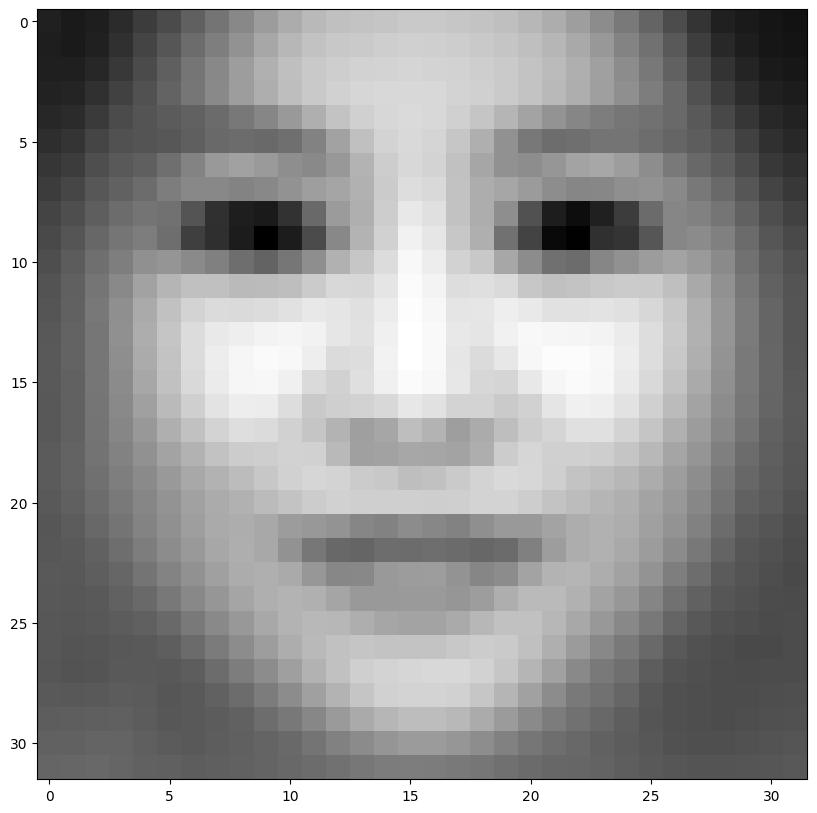

In [ ]:
averageim = np.array(X[0], 'f')

for imname in X[1:]:
    averageim += np.array(imname)

averageim /= len(X)

plt.rcParams['figure.figsize'] = [10, 10]
plt.imshow(averageim, cmap=plt.cm.gray)
plt.show()

In [ ]:
# fix random seed for reproducibility
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

w = 32
h = 32

# create a data generator
datagen = ImageDataGenerator(
        samplewise_center=True,  # set each sample mean to 0
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,
        validation_split=0.3) # we don't expect faces to be upside-down so we will not flip vertically


# load and iterate training dataset
train_batch_processing = datagen.flow_from_directory('/path/to/UTKFace-filtered/',
                                       target_size=(w, h),
                                       color_mode='grayscale',
                                       class_mode='categorical',
                                       batch_size=32,
                                       subset='training')
# load and iterate validation dataset
valid_batch_processing = datagen.flow_from_directory('/path/to/UTKFace-filtered/',
                                      target_size=(w, h),
                                      color_mode='grayscale',
                                      class_mode='categorical',
                                      batch_size=32,
                                      subset='validation')

Found 356 images belonging to 12 classes.
Found 144 images belonging to 12 classes.


Epoch 1/10
12/12 [==============================] - 3s 225ms/step - loss: 21.7524 - accuracy: 0.3146 - val_loss: 13.4193 - val_accuracy: 0.3889
Epoch 2/10
12/12 [==============================] - 2s 171ms/step - loss: 14.4197 - accuracy: 0.4916 - val_loss: 5.9303 - val_accuracy: 0.5278
Epoch 3/10
12/12 [==============================] - 2s 161ms/step - loss: 6.9826 - accuracy: 0.4551 - val_loss: 8.1434 - val_accuracy: 0.3403
Epoch 4/10
12/12 [==============================] - 2s 161ms/step - loss: 5.8259 - accuracy: 0.4831 - val_loss: 4.7982 - val_accuracy: 0.5833
Epoch 5/10
12/12 [==============================] - 2s 188ms/step - loss: 5.1050 - accuracy: 0.4775 - val_loss: 4.4021 - val_accuracy: 0.5833
Epoch 6/10
12/12 [==============================] - 2s 192ms/step - loss: 4.1961 - accuracy: 0.5281 - val_loss: 3.1411 - val_accuracy: 0.5833
Epoch 7/10
12/12 [==============================] - 2s 161ms/step - loss: 4.1954 - accuracy: 0.5590 - val_loss: 3.4198 - val_accuracy: 0.6181
Epo

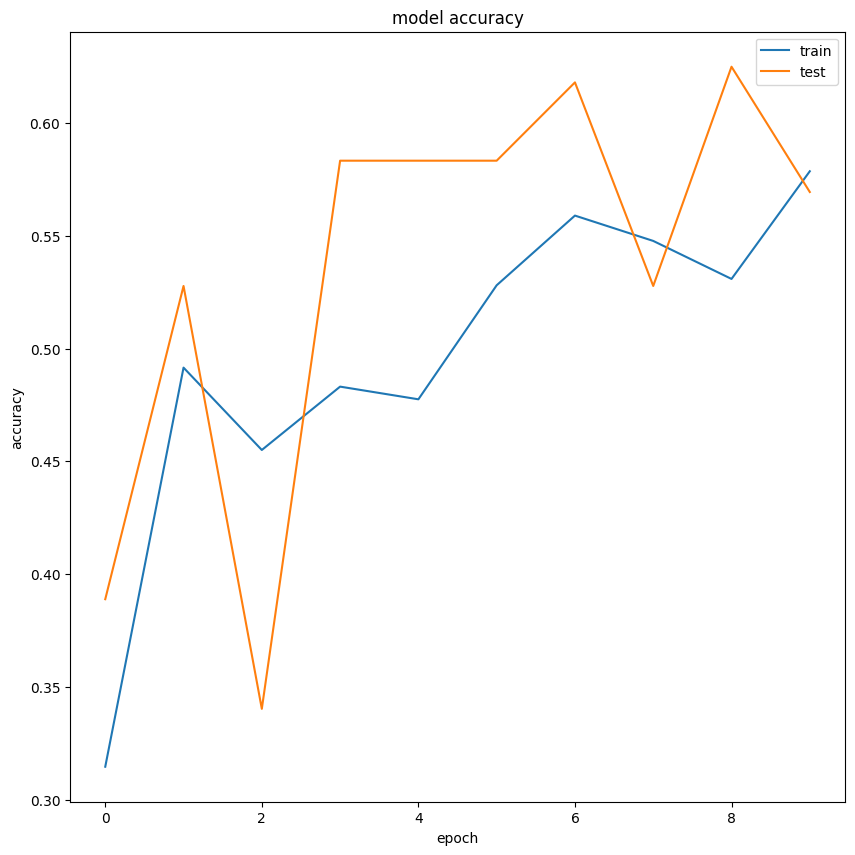

In [ ]:
# Define the model architecture
modelC = Sequential()

# Add convolutional and max pooling layers
modelC.add(Conv2D(32, (3, 3), strides=1, padding="valid", input_shape=(w, h, 1), activation='relu'))
modelC.add(MaxPooling2D(pool_size=(2, 2), padding="valid"))
modelC.add(Flatten())
modelC.add(Dense(num_classes, activation='softmax'))  # Adjust the number of units to match your number of classes

# Compile the model
modelC.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
history = modelC.fit(train_batch_processing, validation_data=valid_batch_processing, epochs=10, verbose=1)


# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Epoch 1/10
11/11 [==============================] - 1s 50ms/step - loss: 1.6933 - accuracy: 0.4581 - val_loss: 1.6940 - val_accuracy: 0.4880
Epoch 2/10
11/11 [==============================] - 0s 38ms/step - loss: 1.3614 - accuracy: 0.5180 - val_loss: 1.4164 - val_accuracy: 0.5301
Epoch 3/10
11/11 [==============================] - 0s 34ms/step - loss: 1.2270 - accuracy: 0.5988 - val_loss: 1.3275 - val_accuracy: 0.6386
Epoch 4/10
11/11 [==============================] - 0s 35ms/step - loss: 1.1365 - accuracy: 0.6527 - val_loss: 1.3050 - val_accuracy: 0.6386
Epoch 5/10
11/11 [==============================] - 0s 32ms/step - loss: 1.0928 - accuracy: 0.6557 - val_loss: 1.3035 - val_accuracy: 0.6145
Epoch 6/10
11/11 [==============================] - 0s 32ms/step - loss: 1.0554 - accuracy: 0.6677 - val_loss: 1.2518 - val_accuracy: 0.6145
Epoch 7/10
11/11 [==============================] - 0s 37ms/step - loss: 0.9976 - accuracy: 0.6826 - val_loss: 1.2378 - val_accuracy: 0.6506
Epoch 8/10
11

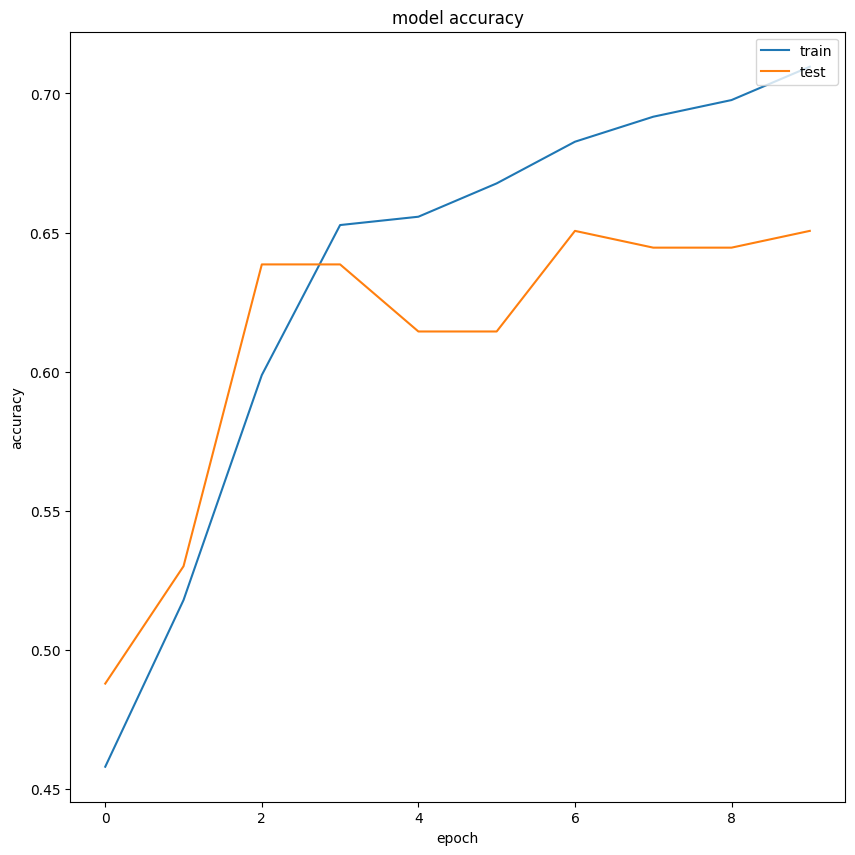

In [ ]:
# Define the model architecture
modelC = Sequential()

# Add convolutional and max pooling layers
modelC.add(Conv2D(32, (3, 3), strides=1, padding="valid", input_shape=(w, h, 1), activation='relu'))
modelC.add(MaxPooling2D(pool_size=(2, 2), padding="valid"))
modelC.add(Flatten())
modelC.add(Dense(num_classes, activation='softmax'))  # Adjust the number of units to match your number of classes

# Compile the model
modelC.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
history = modelC.fit(X, Y, validation_split=0.33, epochs=10, verbose=1)


# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Epoch 1/10
12/12 [==============================] - 3s 201ms/step - loss: 42.6077 - accuracy: 0.4101 - val_loss: 28.3388 - val_accuracy: 0.1875
Epoch 2/10
12/12 [==============================] - 2s 169ms/step - loss: 23.6917 - accuracy: 0.4551 - val_loss: 9.0212 - val_accuracy: 0.5069
Epoch 3/10
12/12 [==============================] - 2s 165ms/step - loss: 11.7704 - accuracy: 0.4775 - val_loss: 9.7914 - val_accuracy: 0.4792
Epoch 4/10
12/12 [==============================] - 2s 204ms/step - loss: 9.3354 - accuracy: 0.5506 - val_loss: 6.9125 - val_accuracy: 0.4167
Epoch 5/10
12/12 [==============================] - 2s 202ms/step - loss: 6.4152 - accuracy: 0.5478 - val_loss: 5.4936 - val_accuracy: 0.6528
Epoch 6/10
12/12 [==============================] - 2s 168ms/step - loss: 5.1712 - accuracy: 0.4972 - val_loss: 4.4843 - val_accuracy: 0.6875
Epoch 7/10
12/12 [==============================] - 2s 170ms/step - loss: 3.8035 - accuracy: 0.5674 - val_loss: 4.8083 - val_accuracy: 0.6528
Ep

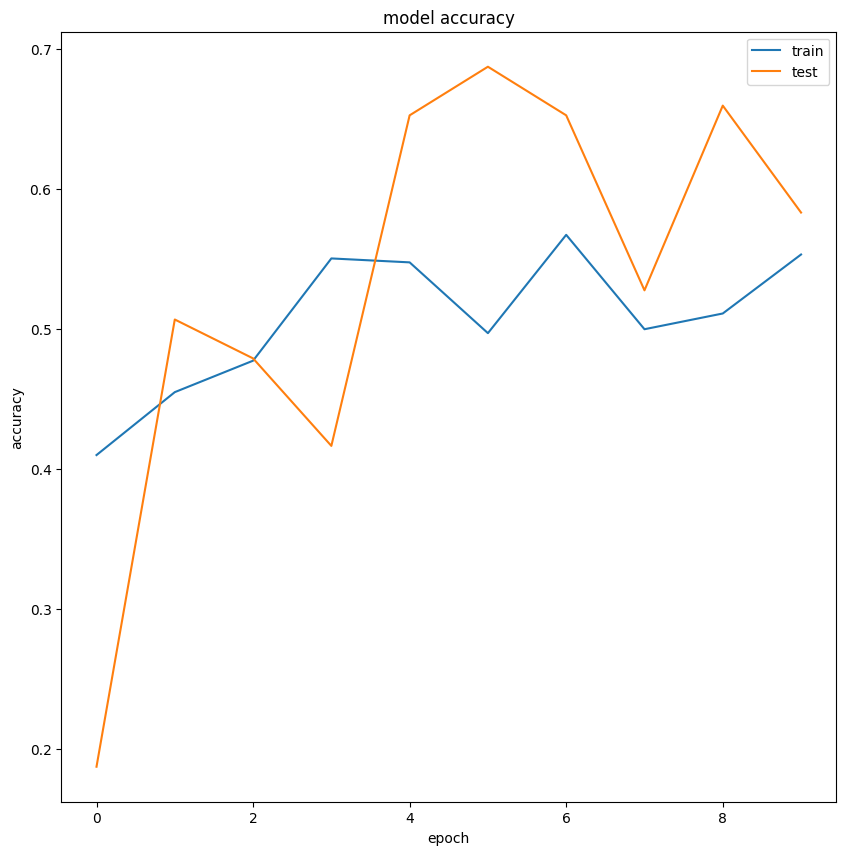

In [ ]:
np.random.seed(seed)
tf.random.set_seed(seed)

modelC = Sequential()
modelC.add(Conv2D(32, (3, 3), strides=1, padding="valid", input_shape=(w, h,1), activation='relu',))
modelC.add(MaxPooling2D(pool_size=(2, 2), padding="valid"))

modelC.add(Flatten())
modelC.add(Dense(128, activation='relu'))
modelC.add(Dense(num_classes, activation='softmax'))


modelC.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
history = modelC.fit(train_batch_processing, validation_data=valid_batch_processing, epochs=10, verbose=1)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Epoch 1/10
11/11 [==============================] - 1s 58ms/step - loss: 1.6143 - accuracy: 0.4940 - val_loss: 1.4699 - val_accuracy: 0.5301
Epoch 2/10
11/11 [==============================] - 0s 29ms/step - loss: 1.2835 - accuracy: 0.5240 - val_loss: 1.3588 - val_accuracy: 0.6265
Epoch 3/10
11/11 [==============================] - 0s 28ms/step - loss: 1.1510 - accuracy: 0.6826 - val_loss: 1.2899 - val_accuracy: 0.6265
Epoch 4/10
11/11 [==============================] - 0s 26ms/step - loss: 1.0626 - accuracy: 0.6617 - val_loss: 1.2455 - val_accuracy: 0.6566
Epoch 5/10
11/11 [==============================] - 0s 29ms/step - loss: 0.9886 - accuracy: 0.6796 - val_loss: 1.2508 - val_accuracy: 0.6205
Epoch 6/10
11/11 [==============================] - 0s 26ms/step - loss: 0.9518 - accuracy: 0.6707 - val_loss: 1.2020 - val_accuracy: 0.6506
Epoch 7/10
11/11 [==============================] - 0s 29ms/step - loss: 0.9021 - accuracy: 0.6886 - val_loss: 1.2295 - val_accuracy: 0.6386
Epoch 8/10
11

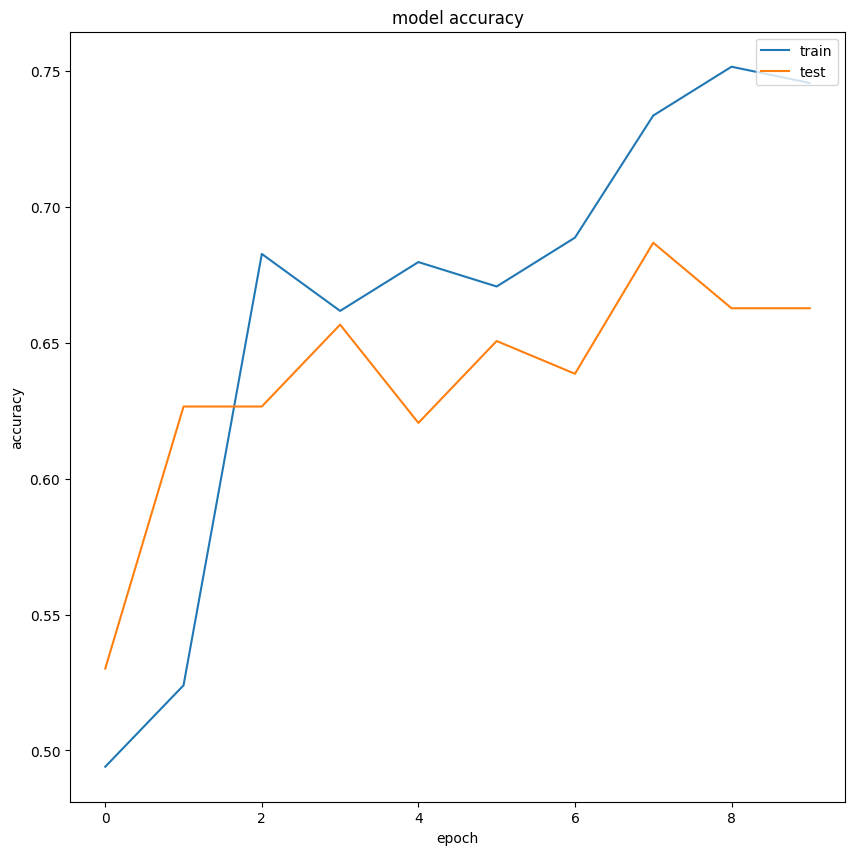

In [ ]:
np.random.seed(seed)
tf.random.set_seed(seed)

modelC = Sequential()
modelC.add(Conv2D(32, (3, 3), strides=1, padding="valid", input_shape=(w, h,1), activation='relu',))
modelC.add(MaxPooling2D(pool_size=(2, 2), padding="valid"))

modelC.add(Flatten())
modelC.add(Dense(128, activation='relu'))
modelC.add(Dense(num_classes, activation='softmax'))


modelC.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
history = modelC.fit(X, Y, validation_split=0.33, epochs=10, verbose=1)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Epoch 1/10
12/12 [==============================] - 3s 211ms/step - loss: 68.5675 - accuracy: 0.3989 - val_loss: 31.6771 - val_accuracy: 0.5972
Epoch 2/10
12/12 [==============================] - 2s 181ms/step - loss: 31.1882 - accuracy: 0.4972 - val_loss: 14.5886 - val_accuracy: 0.5139
Epoch 3/10
12/12 [==============================] - 3s 258ms/step - loss: 15.5591 - accuracy: 0.4551 - val_loss: 13.0401 - val_accuracy: 0.4375
Epoch 4/10
12/12 [==============================] - 2s 183ms/step - loss: 12.9308 - accuracy: 0.4607 - val_loss: 9.9169 - val_accuracy: 0.6875
Epoch 5/10
12/12 [==============================] - 2s 180ms/step - loss: 8.5662 - accuracy: 0.5562 - val_loss: 5.3226 - val_accuracy: 0.5833
Epoch 6/10
12/12 [==============================] - 2s 183ms/step - loss: 4.8865 - accuracy: 0.5506 - val_loss: 3.8356 - val_accuracy: 0.6528
Epoch 7/10
12/12 [==============================] - 3s 243ms/step - loss: 3.7004 - accuracy: 0.5871 - val_loss: 3.6725 - val_accuracy: 0.5903

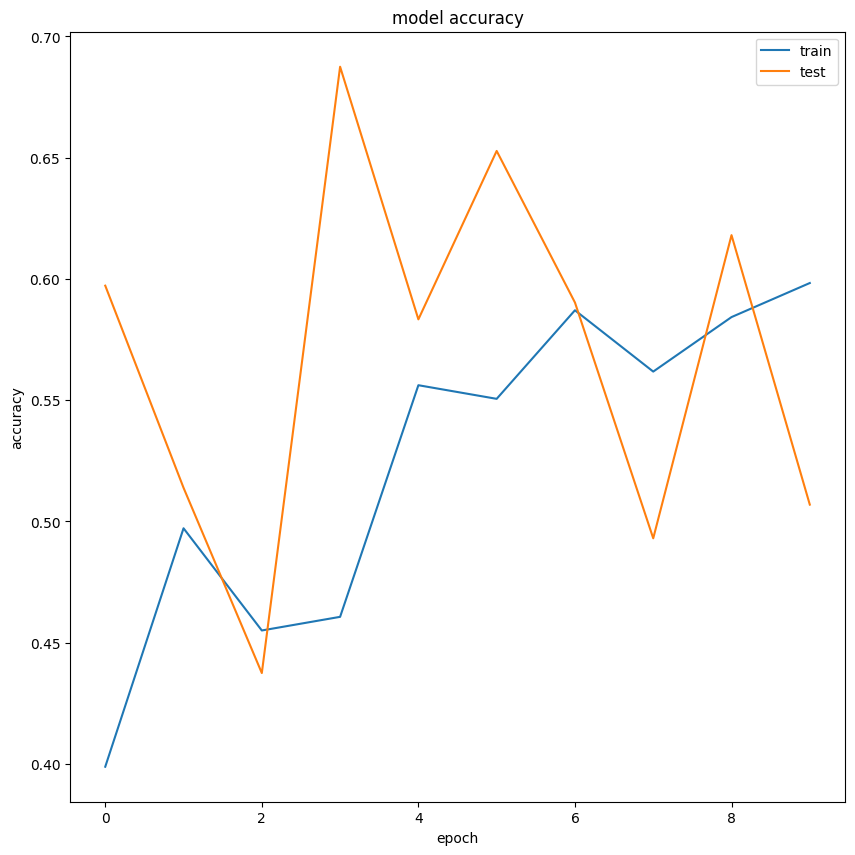

In [ ]:
np.random.seed(seed)
tf.random.set_seed(seed)

modelC = Sequential()
modelC.add(Conv2D(32, (3, 3), strides=1, padding="valid", input_shape=(w, h,1), activation='relu',))
modelC.add(MaxPooling2D(pool_size=(2, 2), padding="valid"))

modelC.add(Flatten())
modelC.add(Dense(256, activation='relu'))
modelC.add(Dense(num_classes, activation='softmax'))


modelC.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
history = modelC.fit(train_batch_processing, validation_data=valid_batch_processing, epochs=10, verbose=1)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Epoch 1/10
11/11 [==============================] - 1s 54ms/step - loss: 1.5817 - accuracy: 0.4731 - val_loss: 1.5085 - val_accuracy: 0.5361
Epoch 2/10
11/11 [==============================] - 1s 64ms/step - loss: 1.2604 - accuracy: 0.5749 - val_loss: 1.2929 - val_accuracy: 0.6265
Epoch 3/10
11/11 [==============================] - 1s 73ms/step - loss: 1.0665 - accuracy: 0.6976 - val_loss: 1.2219 - val_accuracy: 0.6627
Epoch 4/10
11/11 [==============================] - 1s 83ms/step - loss: 0.9908 - accuracy: 0.6916 - val_loss: 1.1722 - val_accuracy: 0.6687
Epoch 5/10
11/11 [==============================] - 1s 79ms/step - loss: 0.8822 - accuracy: 0.7096 - val_loss: 1.2222 - val_accuracy: 0.6265
Epoch 6/10
11/11 [==============================] - 1s 61ms/step - loss: 0.8443 - accuracy: 0.7156 - val_loss: 1.1430 - val_accuracy: 0.6627
Epoch 7/10
11/11 [==============================] - 0s 40ms/step - loss: 0.7905 - accuracy: 0.7066 - val_loss: 1.1996 - val_accuracy: 0.6446
Epoch 8/10
11

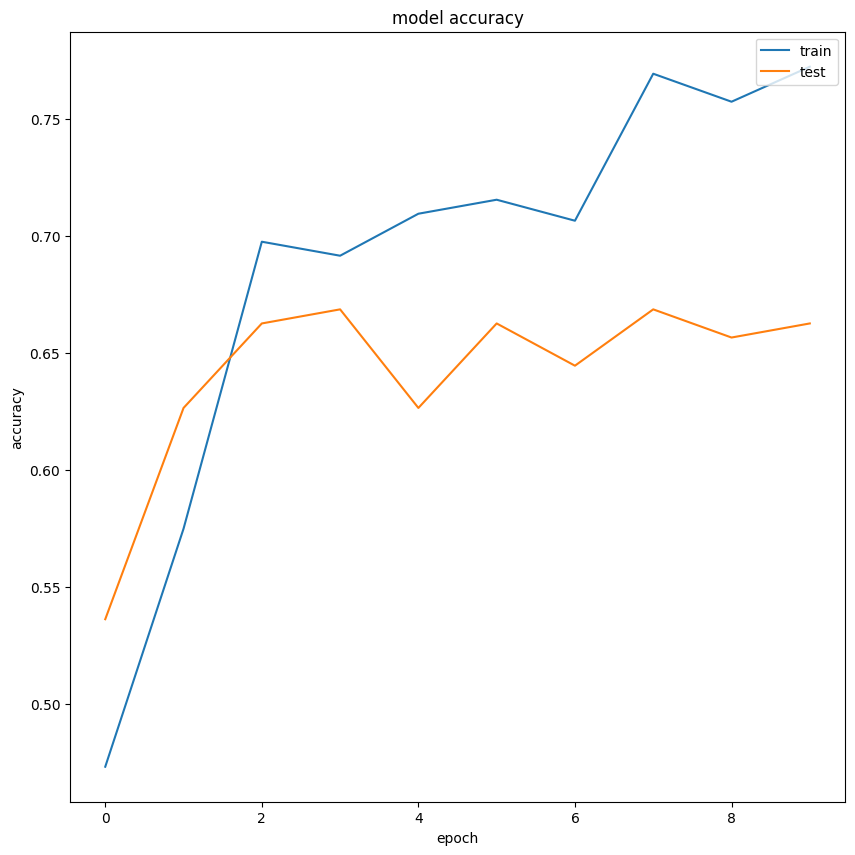

In [ ]:
np.random.seed(seed)
tf.random.set_seed(seed)

modelC = Sequential()
modelC.add(Conv2D(32, (3, 3), strides=1, padding="valid", input_shape=(w, h,1), activation='relu',))
modelC.add(MaxPooling2D(pool_size=(2, 2), padding="valid"))

modelC.add(Flatten())
modelC.add(Dense(256, activation='relu'))
modelC.add(Dense(num_classes, activation='softmax'))


modelC.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
history = modelC.fit(X, Y, validation_split=0.33, epochs=10, verbose=1)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Epoch 1/10
12/12 [==============================] - 3s 199ms/step - loss: 24.7883 - accuracy: 0.3708 - val_loss: 13.5268 - val_accuracy: 0.2847
Epoch 2/10
12/12 [==============================] - 3s 273ms/step - loss: 11.0891 - accuracy: 0.4157 - val_loss: 5.4651 - val_accuracy: 0.5556
Epoch 3/10
12/12 [==============================] - 2s 176ms/step - loss: 5.1177 - accuracy: 0.4494 - val_loss: 2.7243 - val_accuracy: 0.4514
Epoch 4/10
12/12 [==============================] - 2s 175ms/step - loss: 2.8144 - accuracy: 0.4522 - val_loss: 1.7262 - val_accuracy: 0.5694
Epoch 5/10
12/12 [==============================] - 2s 189ms/step - loss: 2.2161 - accuracy: 0.5000 - val_loss: 1.6252 - val_accuracy: 0.6736
Epoch 6/10
12/12 [==============================] - 2s 177ms/step - loss: 1.7531 - accuracy: 0.5337 - val_loss: 1.4927 - val_accuracy: 0.6528
Epoch 7/10
12/12 [==============================] - 2s 186ms/step - loss: 1.4739 - accuracy: 0.6152 - val_loss: 1.2801 - val_accuracy: 0.6458
Epo

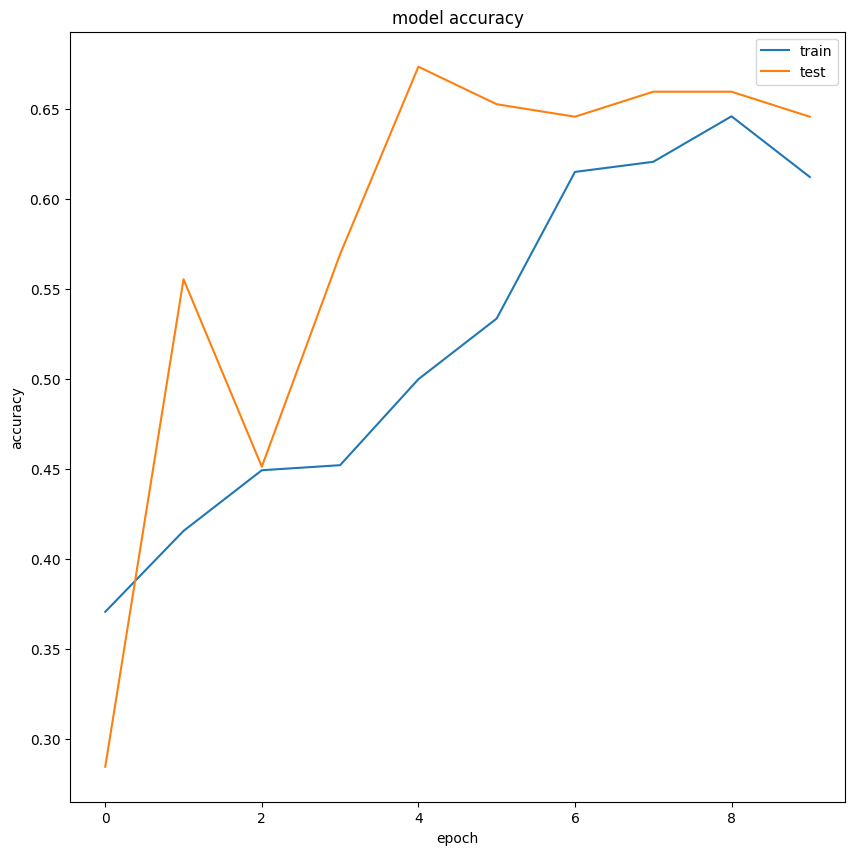

In [ ]:
np.random.seed(seed)
tf.random.set_seed(seed)

modelC = Sequential()
modelC.add(Conv2D(32, (3, 3), strides=1, padding="valid", input_shape=(w, h,1), activation='relu',))
modelC.add(MaxPooling2D(pool_size=(2, 2), padding="valid"))

modelC.add(Flatten())
modelC.add(Dense(256, activation='relu'))
modelC.add(Dense(256, activation='relu'))
modelC.add(Dense(num_classes, activation='softmax'))


modelC.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
history = modelC.fit(train_batch_processing, validation_data=valid_batch_processing, epochs=10, verbose=1)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Epoch 1/10
11/11 [==============================] - 1s 56ms/step - loss: 1.6678 - accuracy: 0.4311 - val_loss: 1.7753 - val_accuracy: 0.2410
Epoch 2/10
11/11 [==============================] - 0s 38ms/step - loss: 1.4598 - accuracy: 0.4132 - val_loss: 1.4316 - val_accuracy: 0.5843
Epoch 3/10
11/11 [==============================] - 0s 40ms/step - loss: 1.1996 - accuracy: 0.6198 - val_loss: 1.3634 - val_accuracy: 0.5843
Epoch 4/10
11/11 [==============================] - 0s 38ms/step - loss: 1.1358 - accuracy: 0.6257 - val_loss: 1.2850 - val_accuracy: 0.5964
Epoch 5/10
11/11 [==============================] - 0s 41ms/step - loss: 1.0656 - accuracy: 0.6617 - val_loss: 1.3255 - val_accuracy: 0.5783
Epoch 6/10
11/11 [==============================] - 0s 38ms/step - loss: 1.0003 - accuracy: 0.6946 - val_loss: 1.1964 - val_accuracy: 0.6747
Epoch 7/10
11/11 [==============================] - 0s 38ms/step - loss: 0.9425 - accuracy: 0.6737 - val_loss: 1.2131 - val_accuracy: 0.6325
Epoch 8/10
11

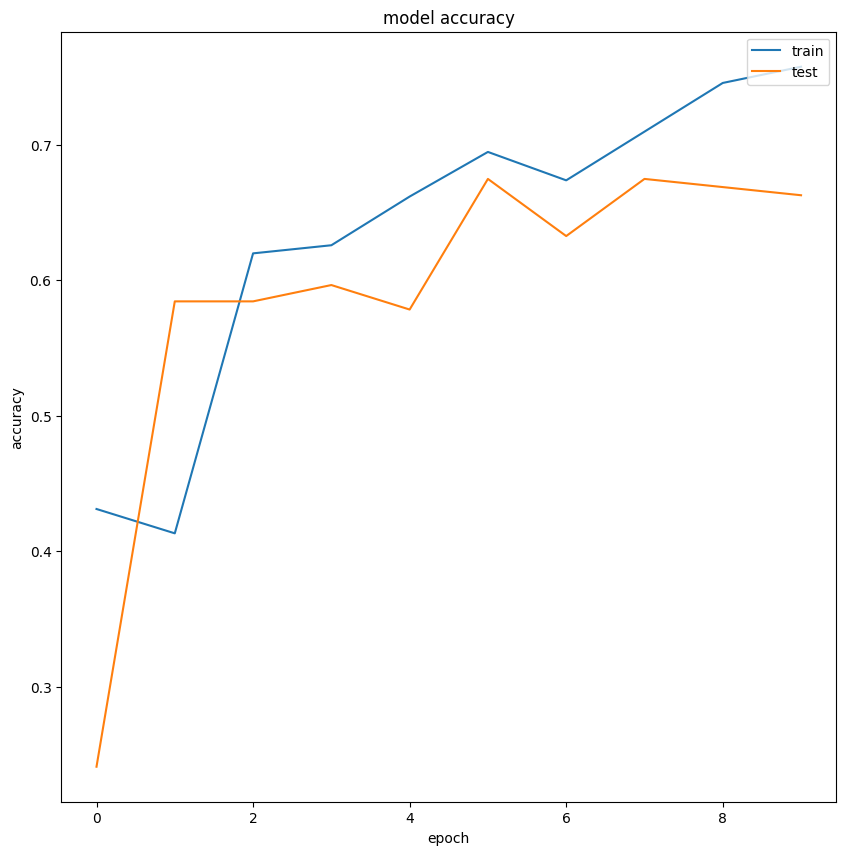

In [ ]:
np.random.seed(seed)
tf.random.set_seed(seed)

modelC = Sequential()
modelC.add(Conv2D(32, (3, 3), strides=1, padding="valid", input_shape=(w, h,1), activation='relu',))
modelC.add(MaxPooling2D(pool_size=(2, 2), padding="valid"))

modelC.add(Flatten())
modelC.add(Dense(256, activation='relu'))
modelC.add(Dense(256, activation='relu'))
modelC.add(Dense(num_classes, activation='softmax'))


modelC.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
history = modelC.fit(X, Y, validation_split=0.33, epochs=10, verbose=1)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

The last one is the best model, it gives the best accuracy and agreement between train and test. The selected model doesn't overfit when trained and tested on the batch processing. All the models have been tested both with batch processing and a normal validation split of the dataset.

kernel Size: 3


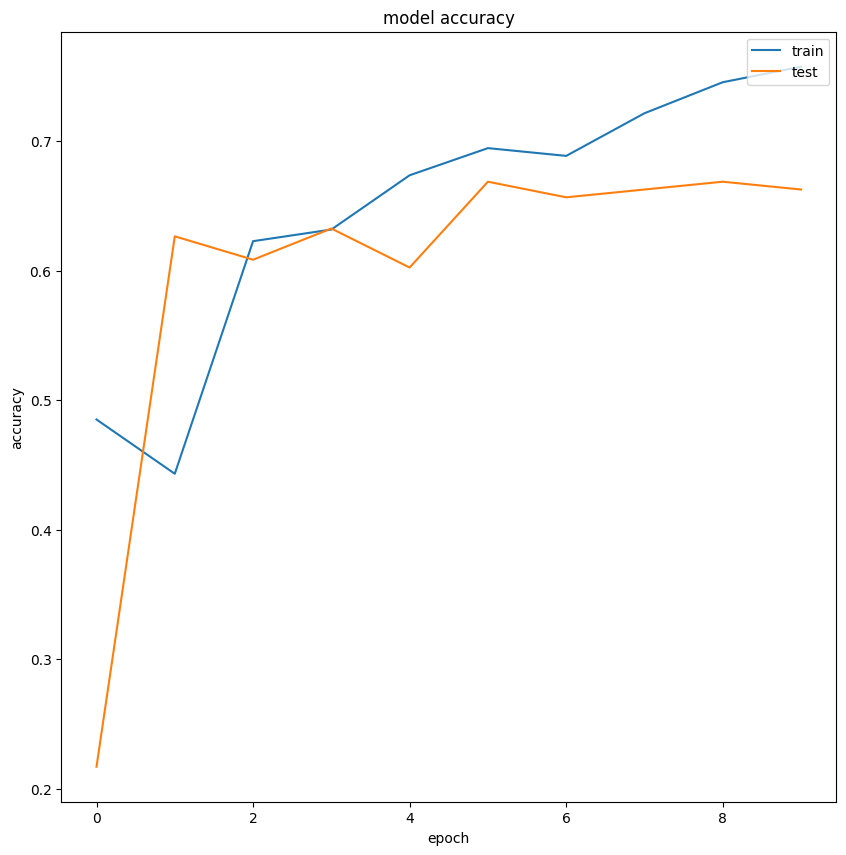

kernel Size: 5


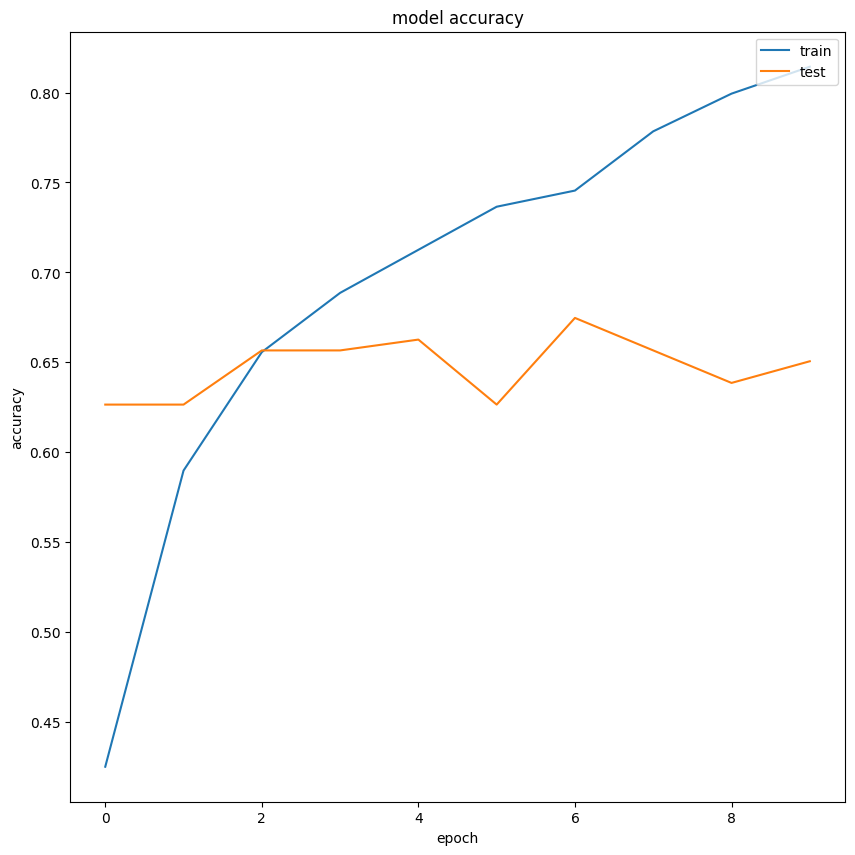

kernel Size: 7


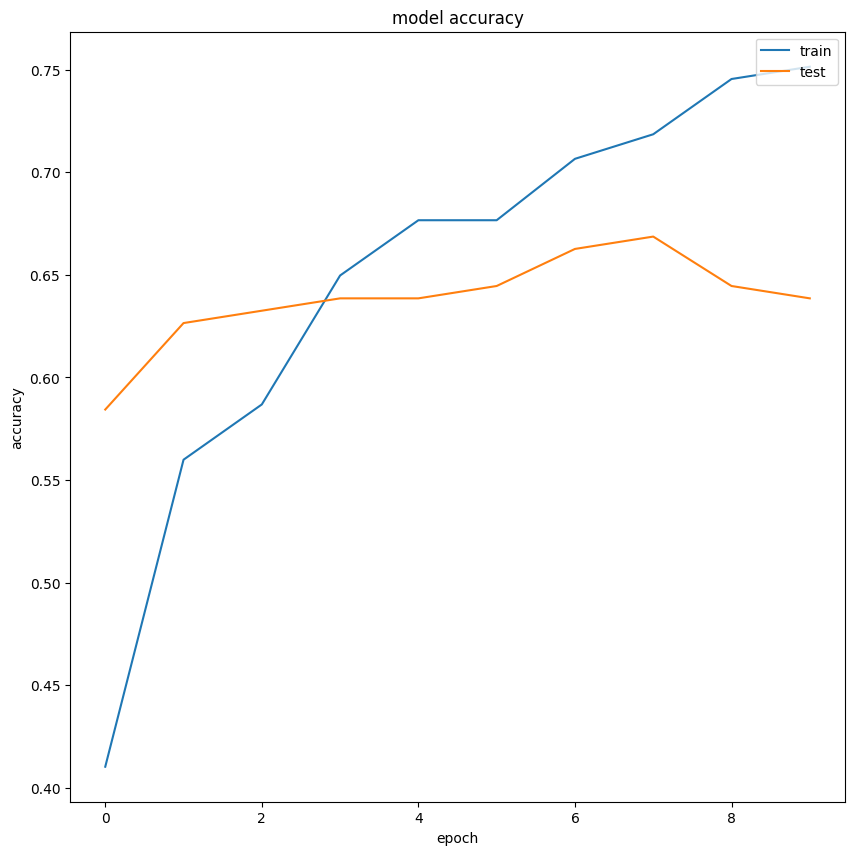

In [ ]:
kernelSizes = [3,5,7]
np.random.seed(seed)
tf.random.set_seed(seed)

for ks in kernelSizes:
    modelC = Sequential()
    modelC.add(Conv2D(32, (ks, ks), strides=1, padding="valid", input_shape=(w, h,1), activation='relu'))
    modelC.add(MaxPooling2D(pool_size=(2, 2), padding="valid"))

    modelC.add(Flatten())
    modelC.add(Dense(256, activation='relu'))
    modelC.add(Dense(256, activation='relu'))
    modelC.add(Dense(num_classes, activation='softmax'))


    modelC.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

    # Fit the model
    history = modelC.fit(X, Y, validation_split=0.33, epochs=10, batch_size=32, verbose=0)

    print("kernel Size:", ks)
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

Batch Size: 8


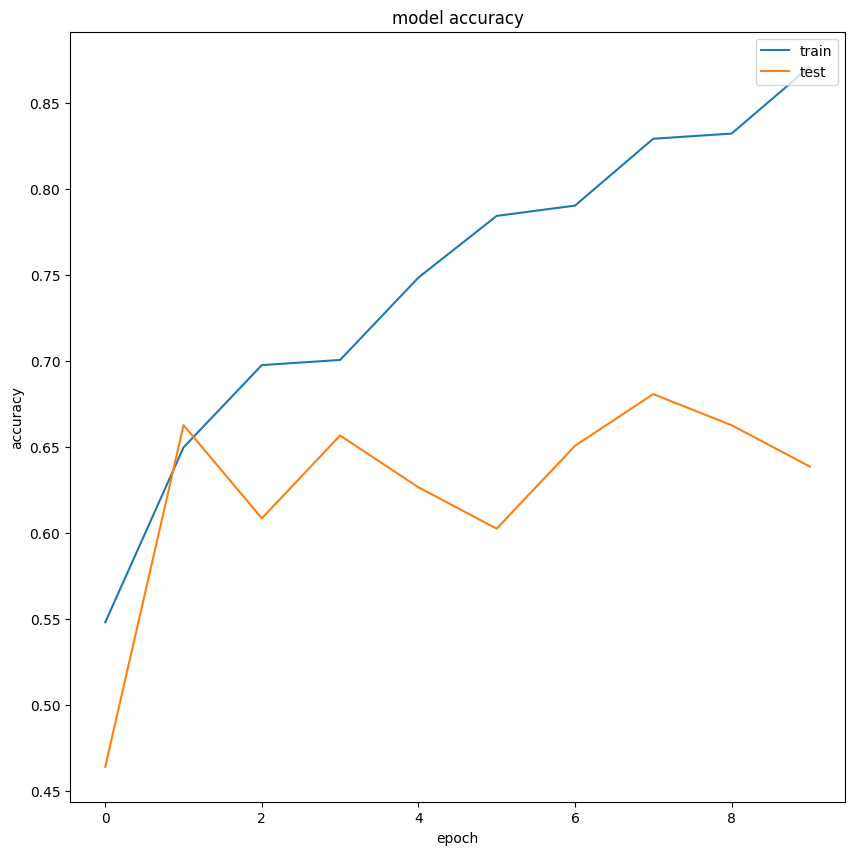

Batch Size: 32


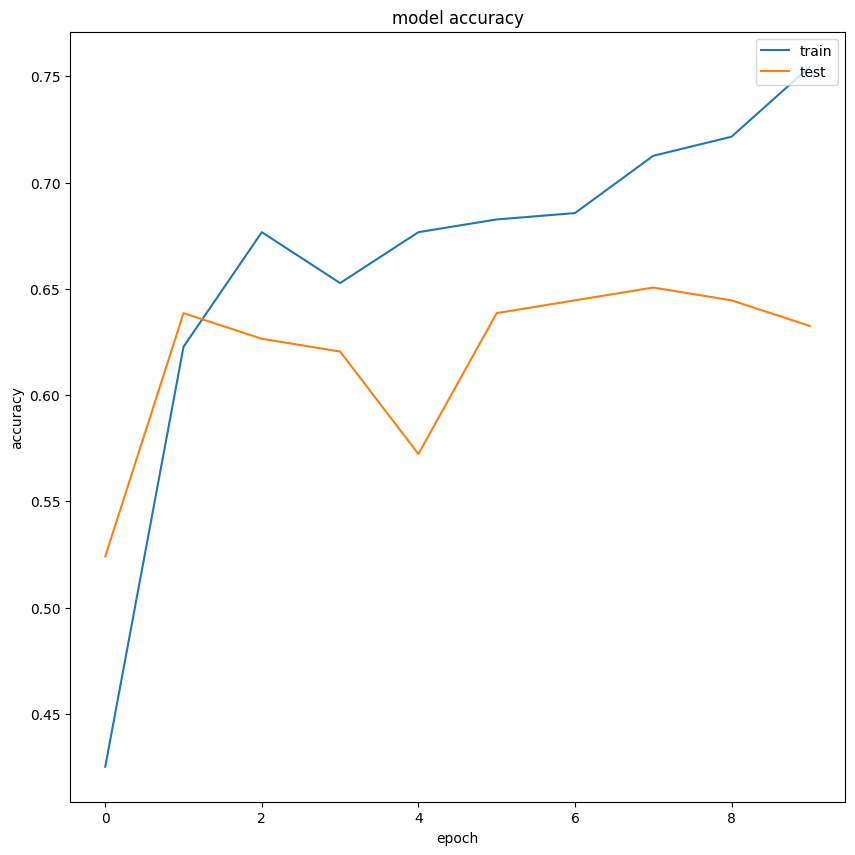

Batch Size: 64


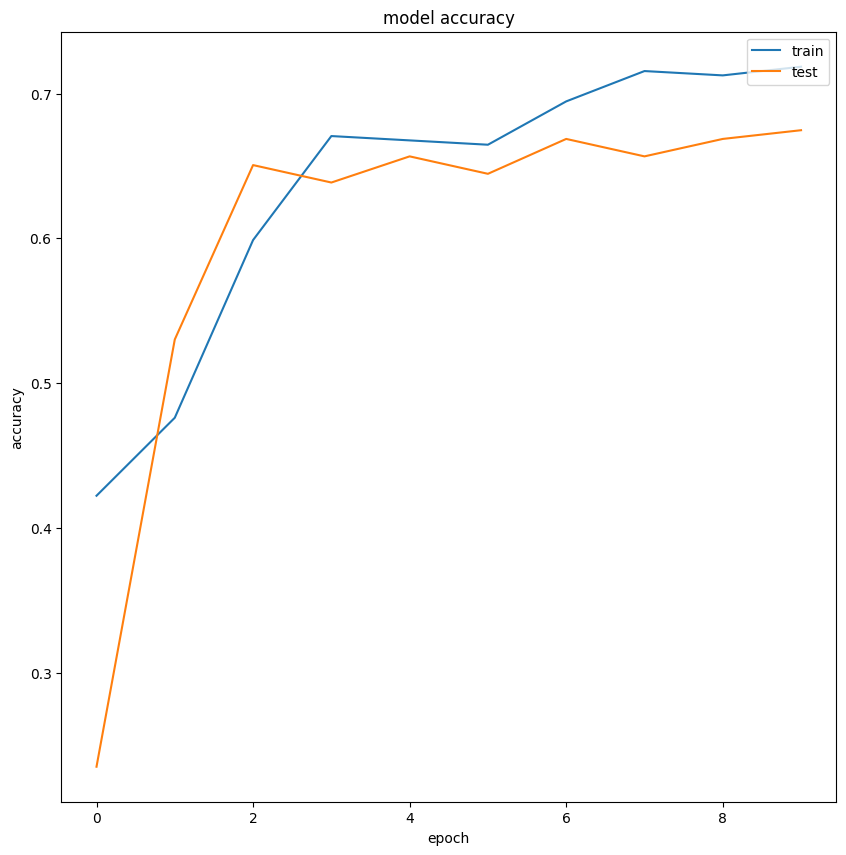

Batch Size: 128


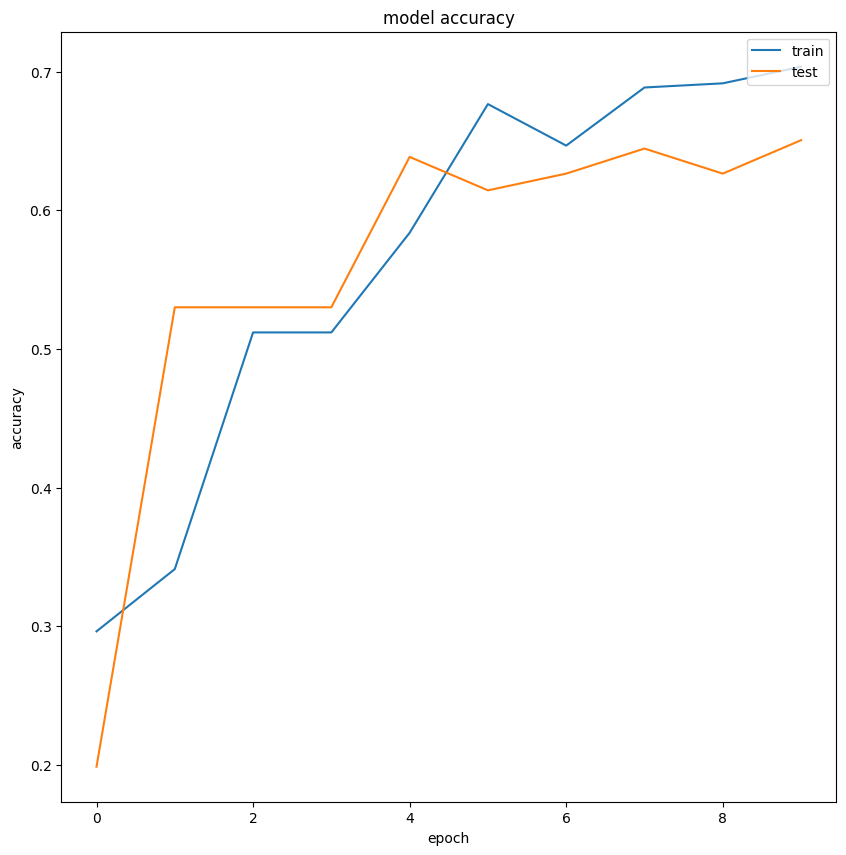

In [ ]:
batchSizes = [8,32,64,128]
np.random.seed(seed)
tf.random.set_seed(seed)

for bs in batchSizes:
    modelC = Sequential()
    modelC.add(Conv2D(32, (5, 5), strides=1, padding="valid", input_shape=(w, h,1), activation='relu'))
    modelC.add(MaxPooling2D(pool_size=(2, 2), padding="valid"))

    modelC.add(Flatten())
    modelC.add(Dense(128, activation='relu'))
    modelC.add(Dense(num_classes, activation='softmax'))


    modelC.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

    # Fit the model
    history = modelC.fit(X, Y, validation_split=0.33, epochs=10, batch_size=bs, verbose=0)

    print("Batch Size:", bs)
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

Best kernel size is 3, and best batch size is 8. Now training the model on the entire dataset and with 20 epochs.

Epoch 1/20
63/63 [==============================] - 2s 18ms/step - loss: 1.4197 - accuracy: 0.5700
Epoch 2/20
63/63 [==============================] - 1s 18ms/step - loss: 1.1263 - accuracy: 0.6560
Epoch 3/20
63/63 [==============================] - 1s 19ms/step - loss: 0.9133 - accuracy: 0.6940
Epoch 4/20
63/63 [==============================] - 1s 19ms/step - loss: 0.8196 - accuracy: 0.7220
Epoch 5/20
63/63 [==============================] - 1s 18ms/step - loss: 0.7310 - accuracy: 0.7420
Epoch 6/20
63/63 [==============================] - 1s 20ms/step - loss: 0.6212 - accuracy: 0.7840
Epoch 7/20
63/63 [==============================] - 2s 29ms/step - loss: 0.6080 - accuracy: 0.7880
Epoch 8/20
63/63 [==============================] - 2s 28ms/step - loss: 0.5233 - accuracy: 0.8020
Epoch 9/20
63/63 [==============================] - 1s 18ms/step - loss: 0.4489 - accuracy: 0.8380
Epoch 10/20
63/63 [==============================] - 1s 18ms/step - loss: 0.3623 - accuracy: 0.8640
Epoch 11/

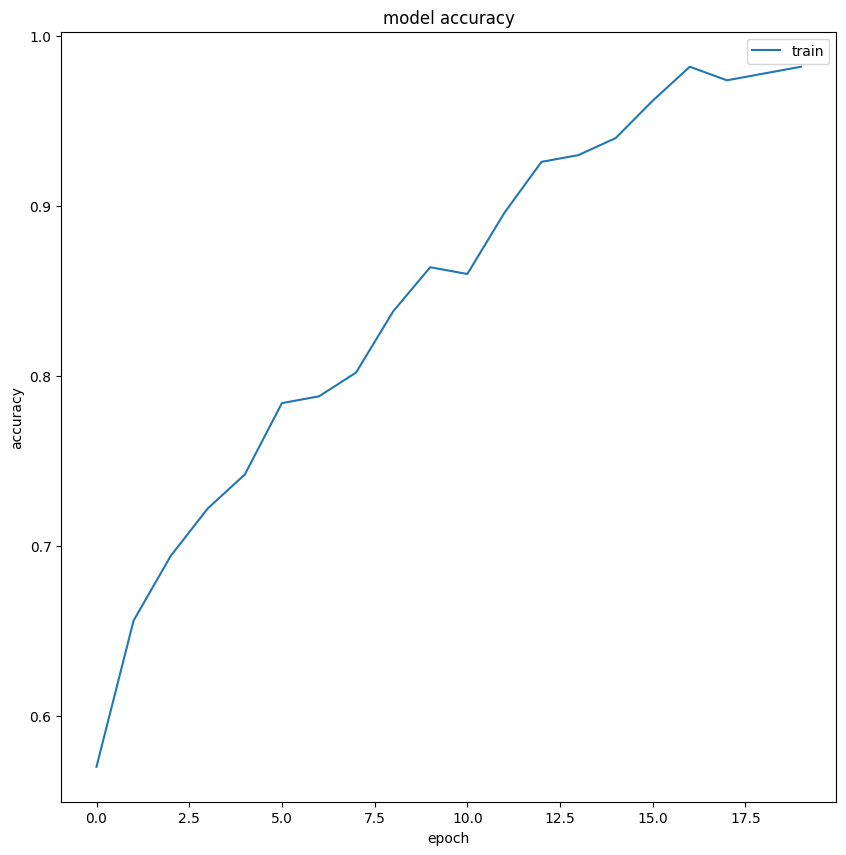

In [ ]:
np.random.seed(seed)
tf.random.set_seed(seed)

modelC = Sequential()
modelC.add(Conv2D(32, (5, 5), strides=1, padding="valid", input_shape=(w, h,1), activation='relu',))
modelC.add(MaxPooling2D(pool_size=(2, 2), padding="valid"))

modelC.add(Flatten())
modelC.add(Dense(256, activation='relu'))
modelC.add(Dense(256, activation='relu'))
modelC.add(Dense(num_classes, activation='softmax'))


modelC.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
history = modelC.fit(X, Y, epochs=20, verbose=1, batch_size=8)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Final model
## 10 unseen images

Testing the accuracy of the model first only on old people (>80 y/o), then on very young people (younger than 10 y/o) and finally on 10 random images.

34


<ipython-input-41-63229d0db30f>:32: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((w, h), Image.ANTIALIAS)


1/1 [==============================] - 0s 135ms/step


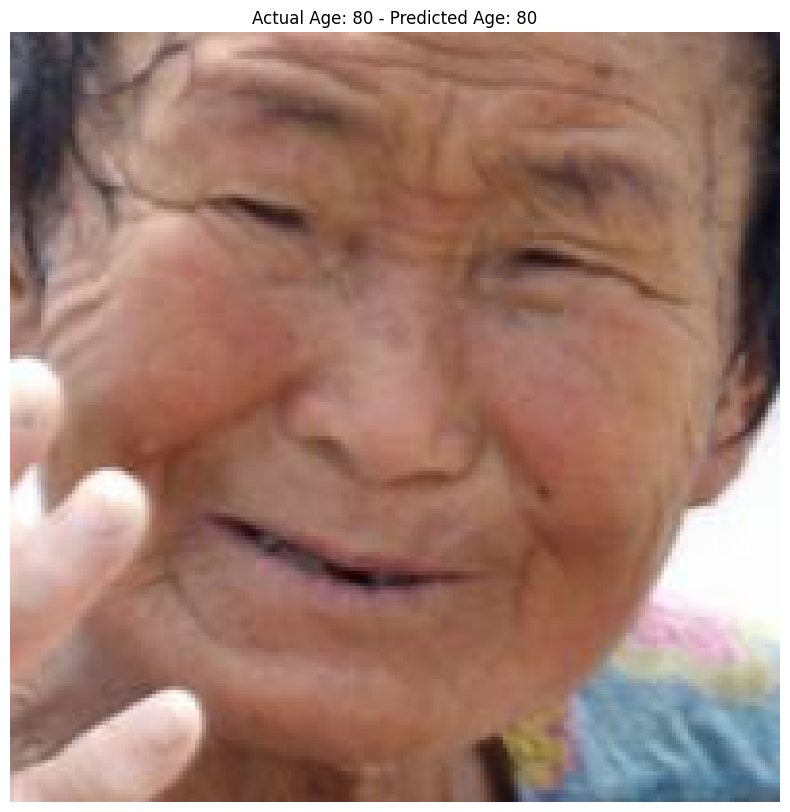

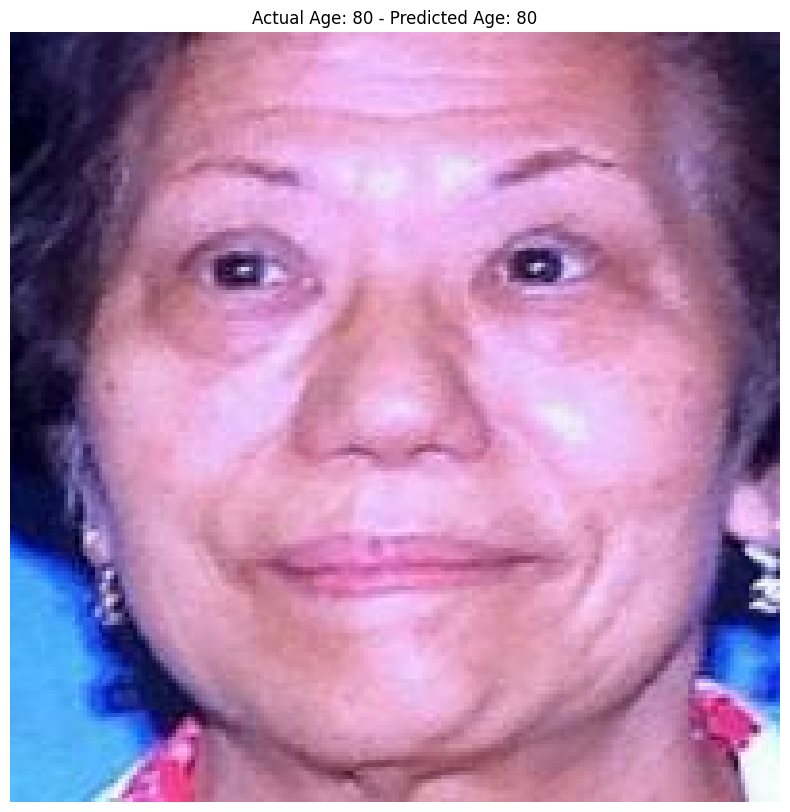

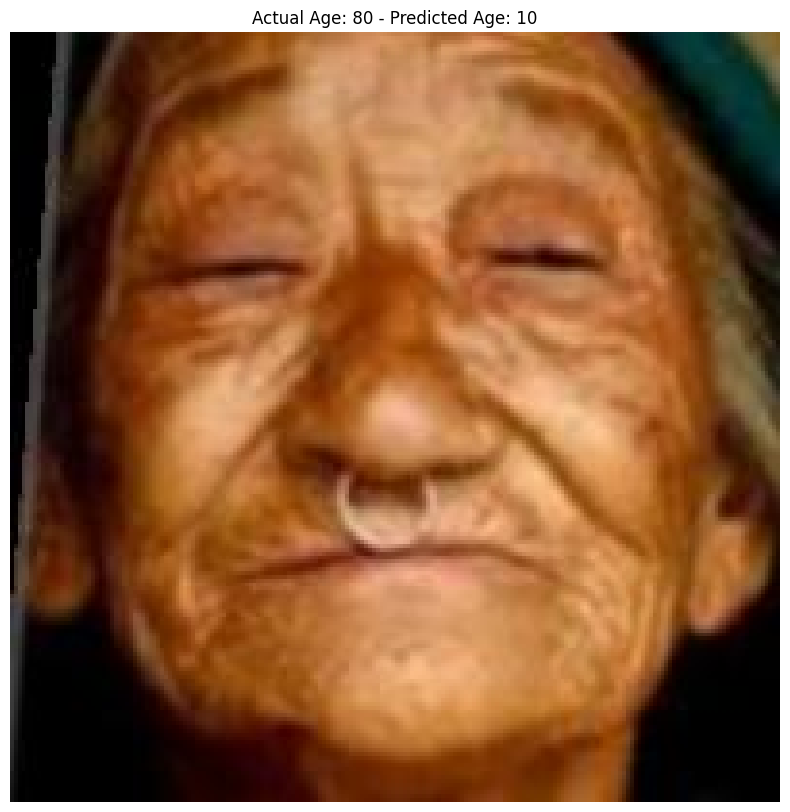

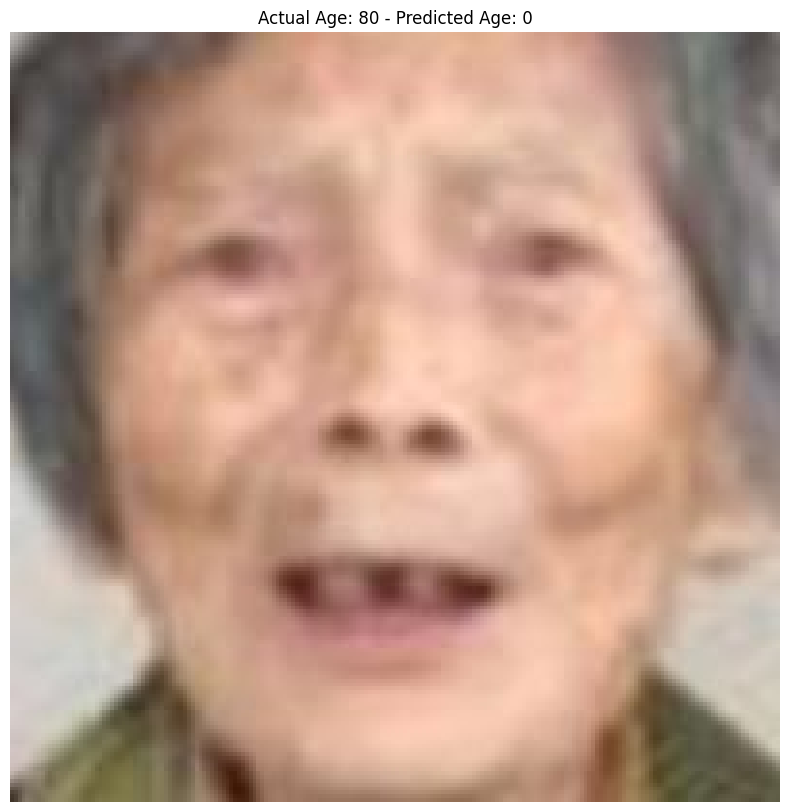

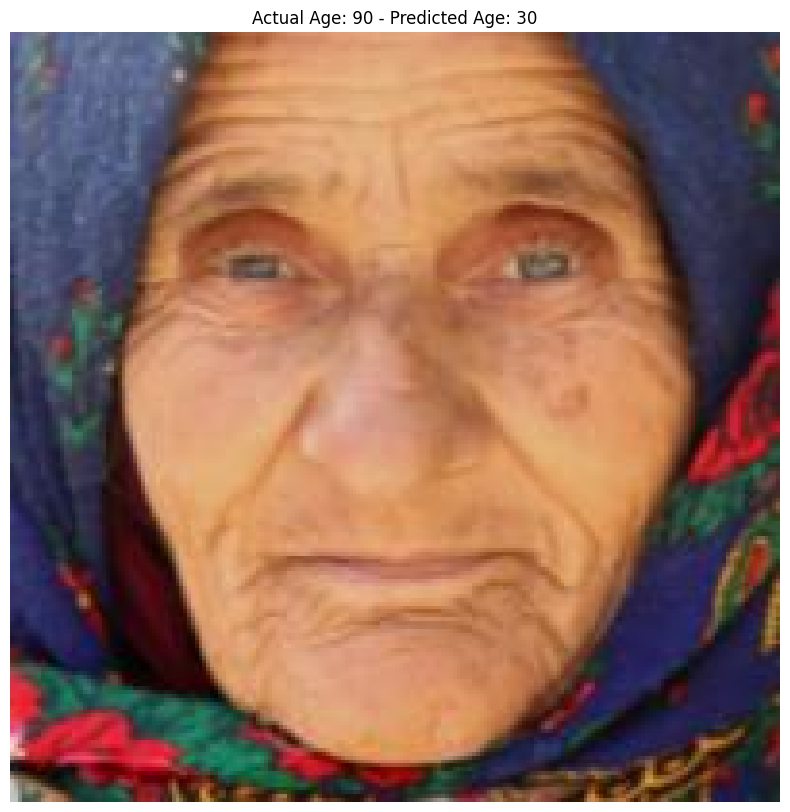

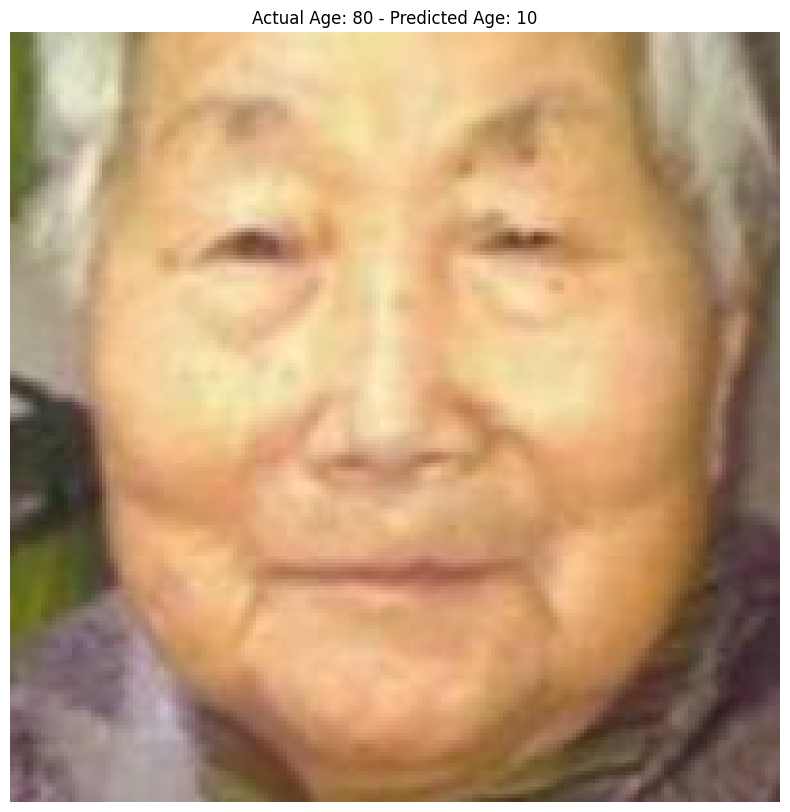

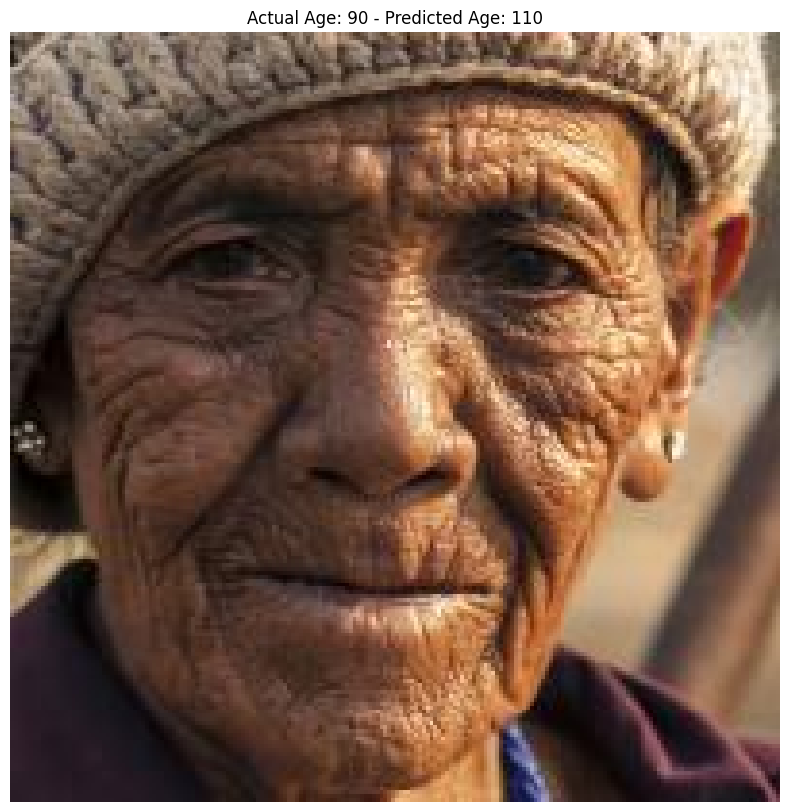

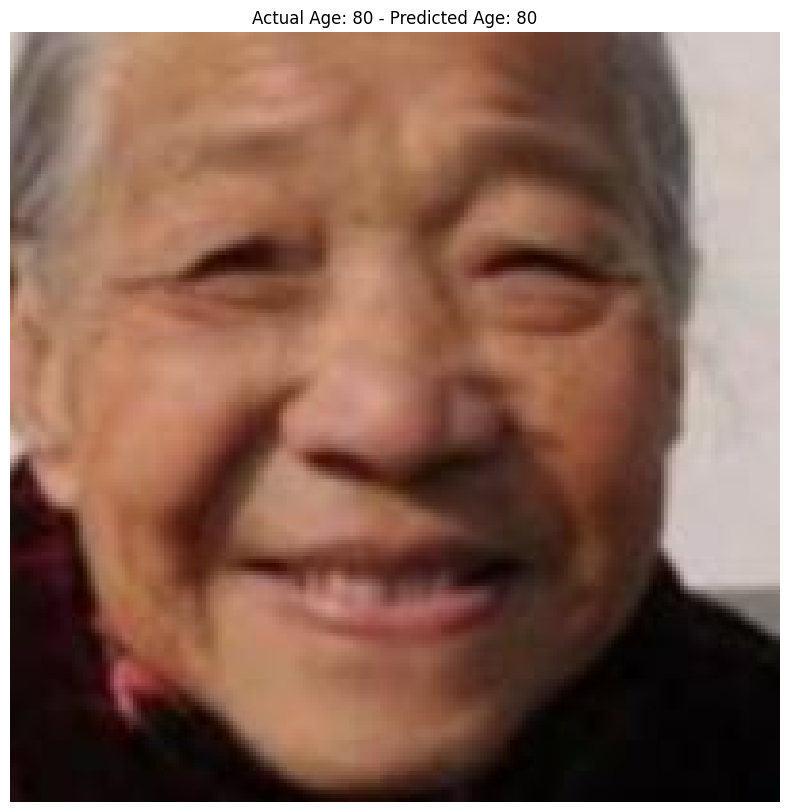

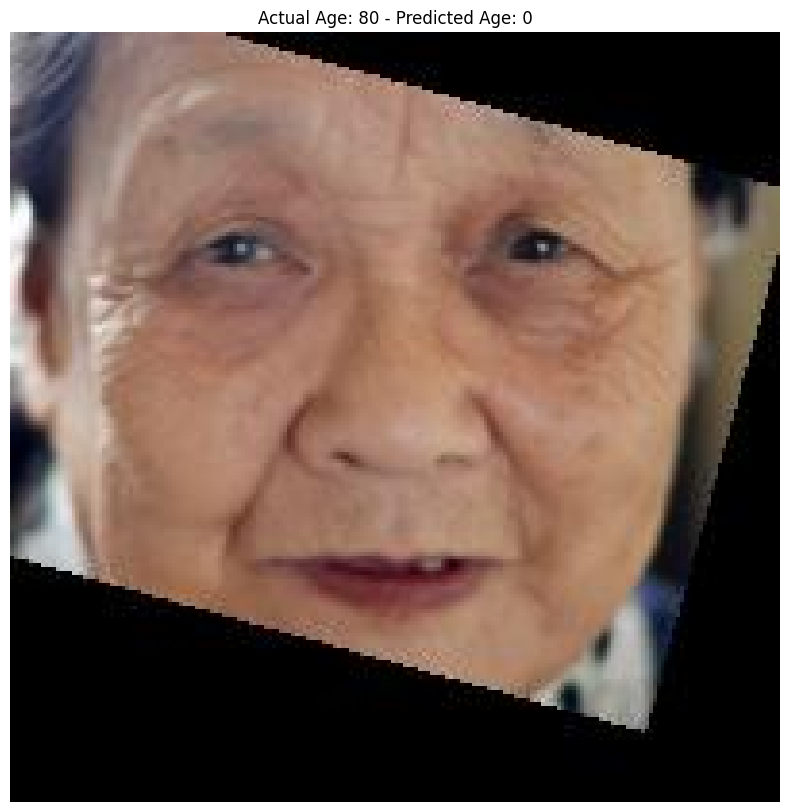

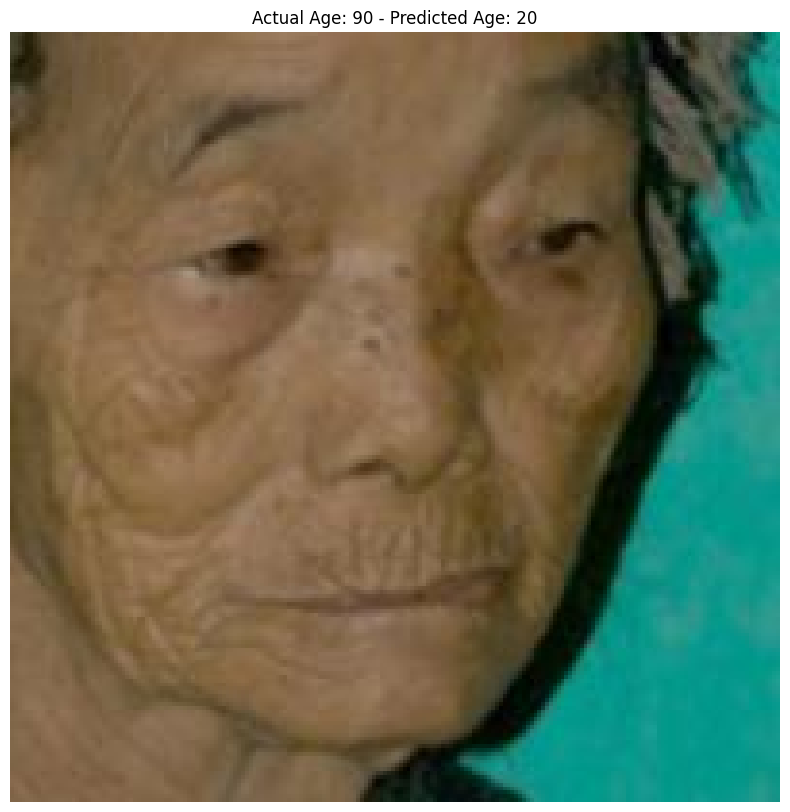

Accuracy: 30.00%


In [ ]:
# Fix random seed for reproducibility
seed = 123
np.random.seed(seed)

w = 32
h = 32

# Function to extract age from filename
def extract_age_from_filename(filename):
    filename_parts = filename.split("/")[-1].split("_")
    age = int(filename_parts[0])
    return age

# Load filenames of all images in UTKFaces folder
all_filenames = glob.glob('/content/drive/MyDrive/Colab Notebooks/UTKFaces/*.jpg')

# Filter out filenames of individuals aged 80 years or older
unseen_filenames_80_or_older = [filename for filename in all_filenames if extract_age_from_filename(filename) >= 80]
print(len(unseen_filenames_80_or_older))
# Check if there are at least 10 unseen images aged 80 years or older
if len(unseen_filenames_80_or_older) >= 10:
    # Randomly select 10 unseen filenames aged 80 years or older
    selected_unseen_filenames = np.random.choice(unseen_filenames_80_or_older, 10, replace=False)

    X_unseen = []

    # Iterate through the selected unseen filenames
    for filename in selected_unseen_filenames:
        # Convert each image to grayscale
        im = Image.open(filename).convert('L')
        # Resize the images
        im = im.resize((w, h), Image.ANTIALIAS)
        # Convert to numpy array
        arr = np.array(im)
        # Normalize the images
        arr = arr / 255.0
        # Add images to the list
        X_unseen.append(arr)

    # Convert list to numpy array
    X_unseen = np.array(X_unseen)

    # Reshape X_unseen to fit the model input shape
    X_unseen = X_unseen.reshape(X_unseen.shape[0], w, h, 1).astype('float32')

    # Use the model to predict age range for unseen images
    predictions = modelC.predict(X_unseen)

    # Extract actual age range from filenames
    actual_age_ranges = [extract_age_from_filename(filename) // 10 for filename in selected_unseen_filenames]

    # Convert predictions to age range indices
    predicted_age_ranges = np.argmax(predictions, axis=1)

    # Calculate accuracy
    correct_predictions = np.sum(predicted_age_ranges == actual_age_ranges)
    total_predictions = len(actual_age_ranges)
    accuracy = correct_predictions / total_predictions * 100

    # Iterate through each unseen image, its actual age, and predicted age
    for i in range(len(selected_unseen_filenames)):
        # Extract actual age range from filename
        actual_age_range = extract_age_from_filename(selected_unseen_filenames[i]) // 10
        # Extract predicted age range
        predicted_age_range = predicted_age_ranges[i]
        # Load the original image
        image = Image.open(selected_unseen_filenames[i])
        # Plot the image
        plt.imshow(image)
        plt.title(f"Actual Age: {actual_age_range * 10} - Predicted Age: {predicted_age_range * 10}")
        plt.axis('off')
        plt.show()

    print(f"Accuracy: {accuracy:.2f}%")
else:
    print("There are not enough unseen images aged 80 years or older.")

282
1/1 [==============================] - 0s 40ms/step


<ipython-input-42-2d2faa0fd6c0>:32: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((w, h), Image.ANTIALIAS)


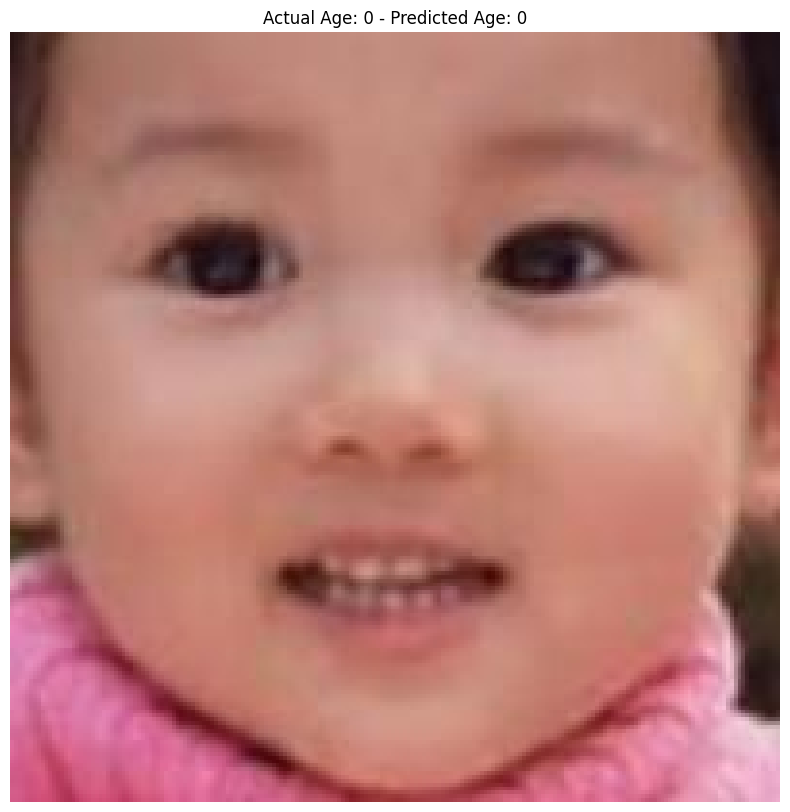

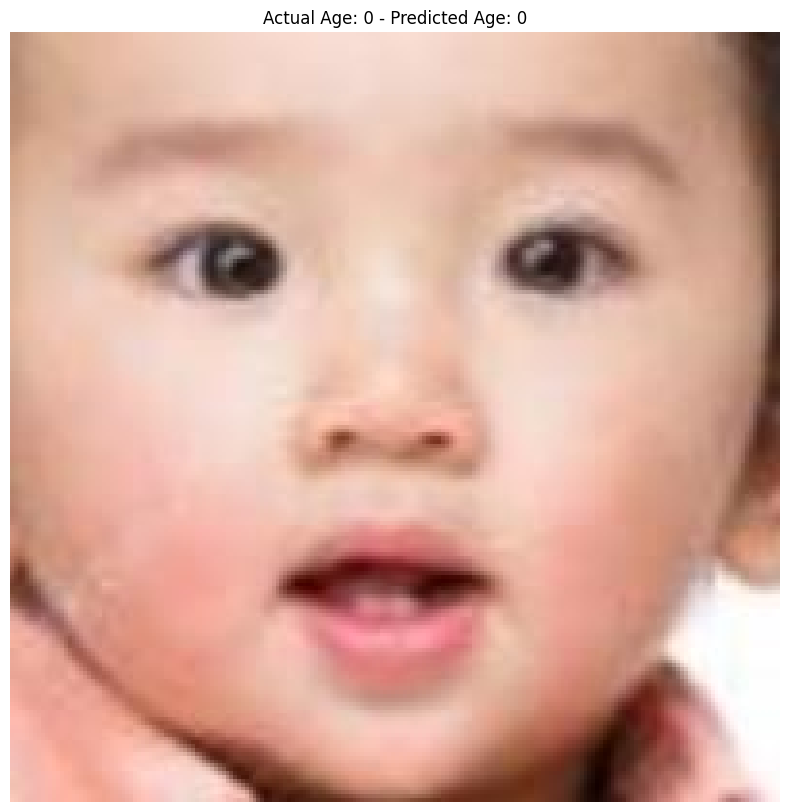

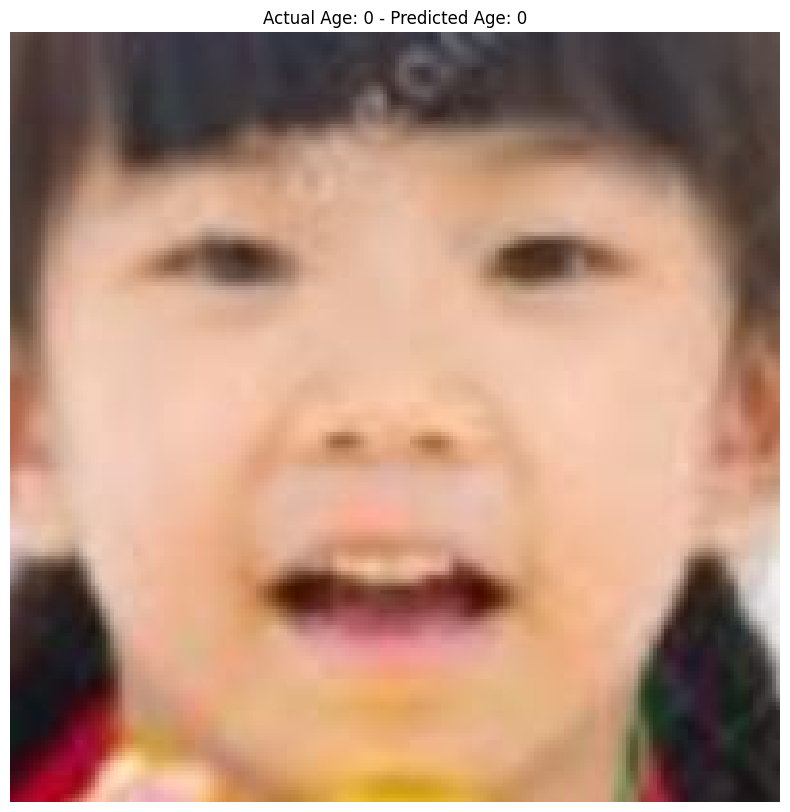

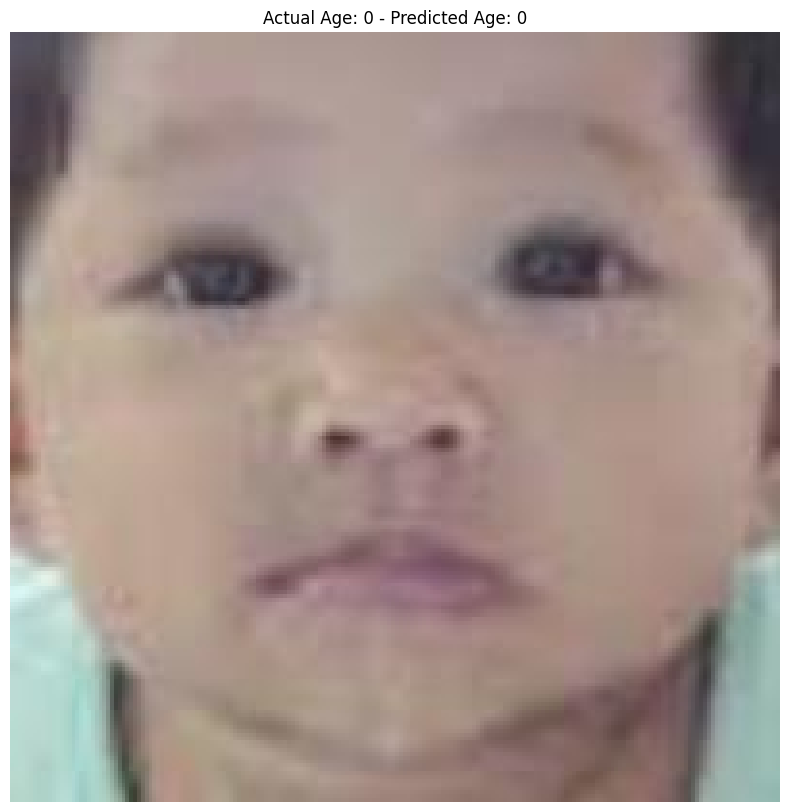

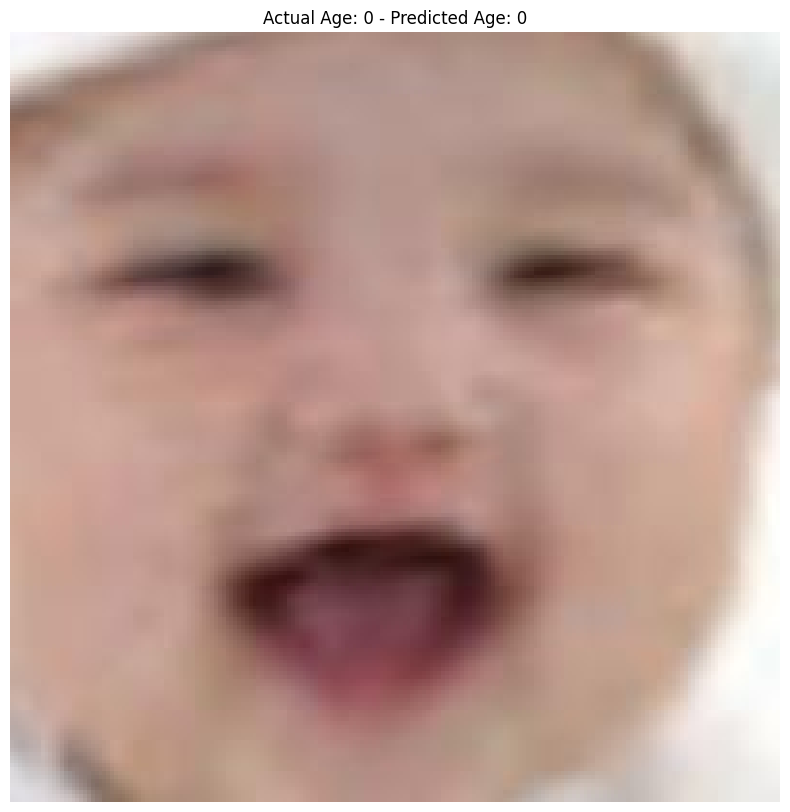

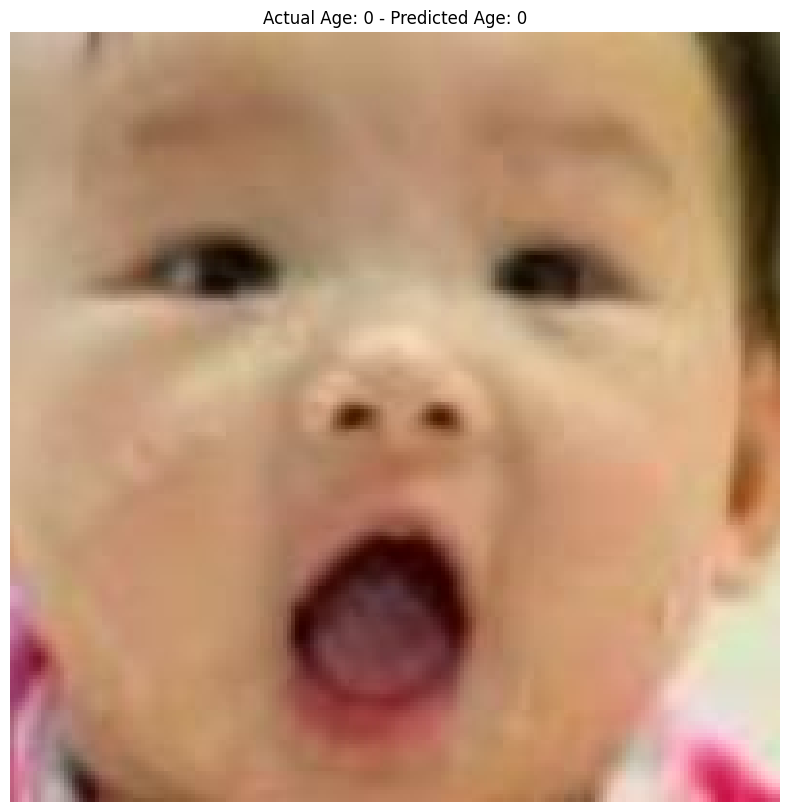

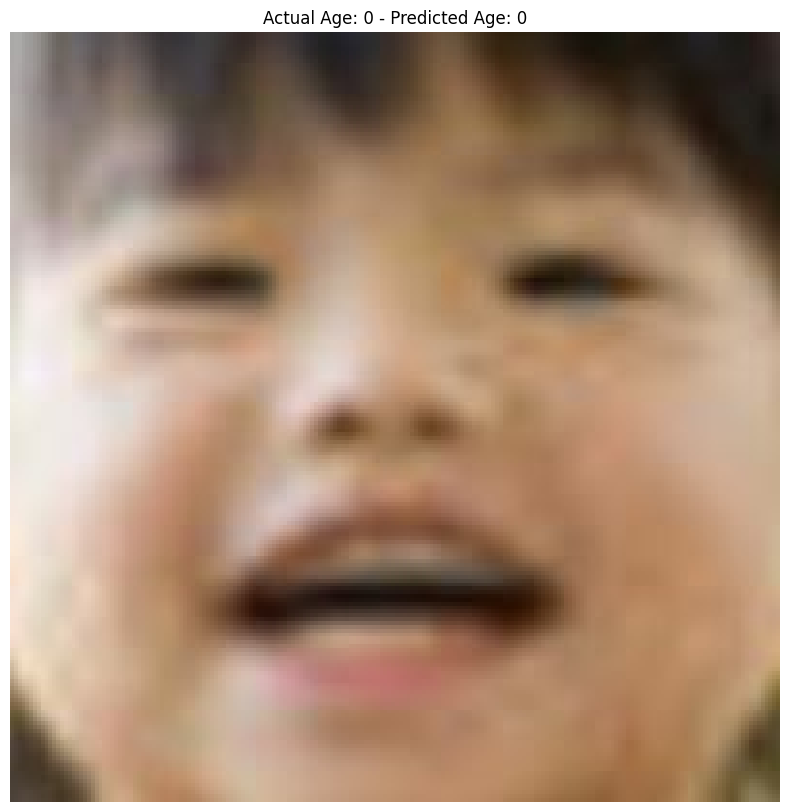

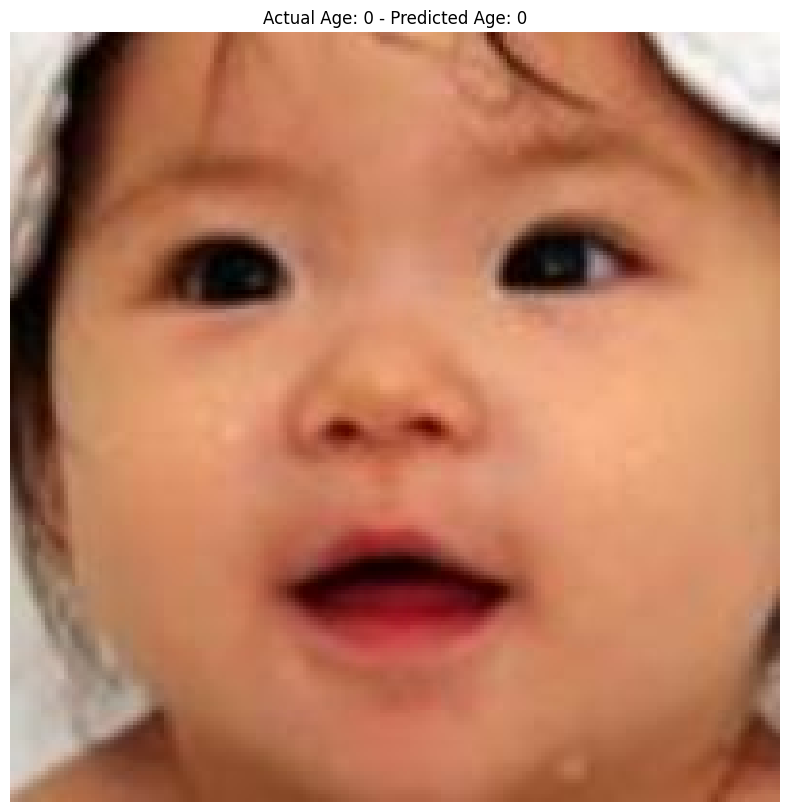

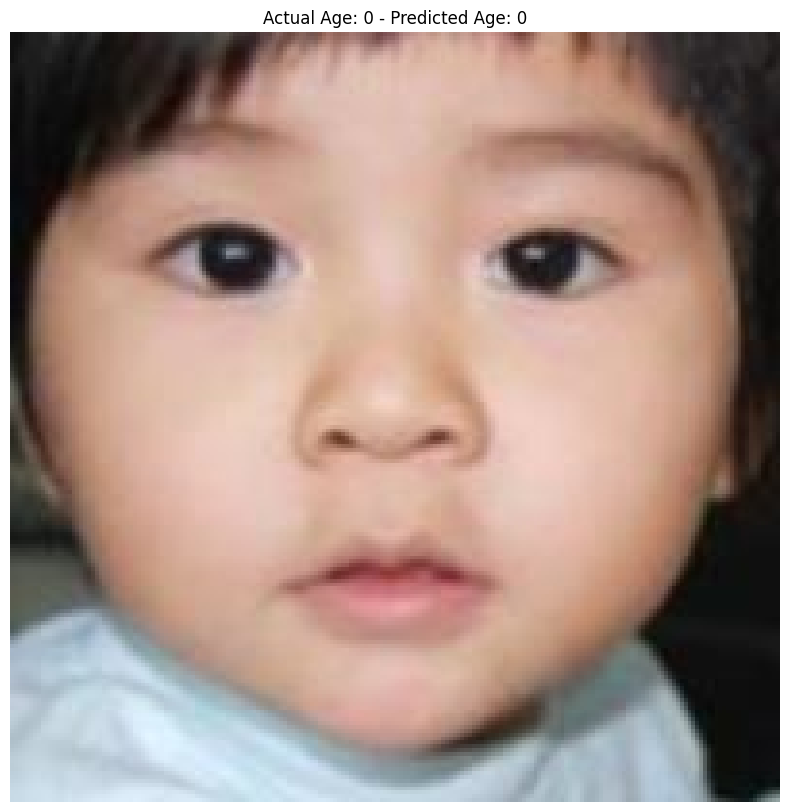

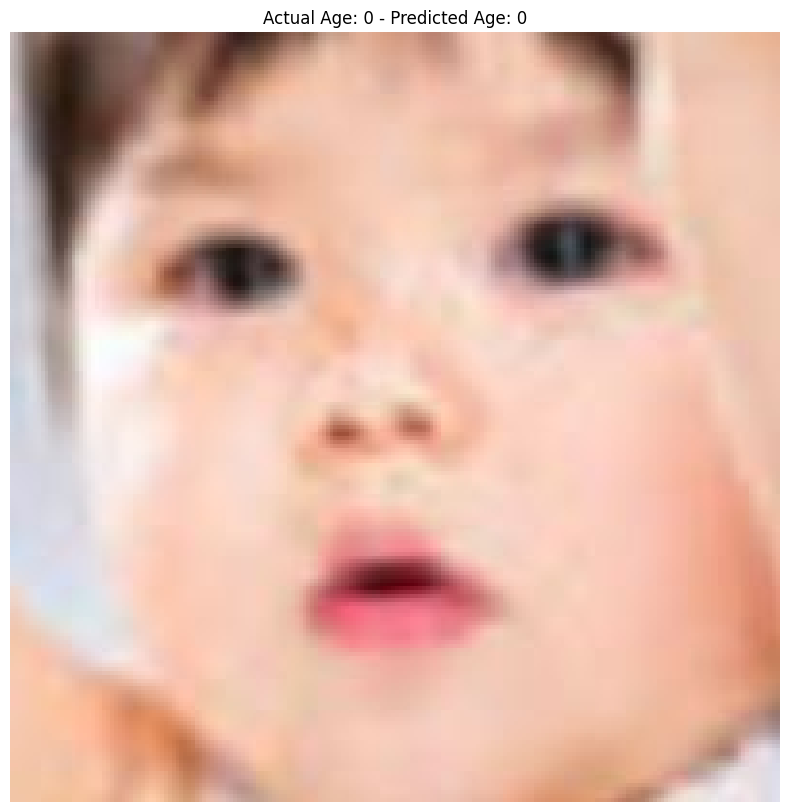

Accuracy: 100.00%


In [ ]:
# Fix random seed for reproducibility
seed = 123
np.random.seed(seed)

w = 32
h = 32

# Function to extract age from filename
def extract_age_from_filename(filename):
    filename_parts = filename.split("/")[-1].split("_")
    age = int(filename_parts[0])
    return age

# Load filenames of all images in UTKFaces folder
all_filenames = glob.glob('/content/drive/MyDrive/Colab Notebooks/UTKFaces/*.jpg')

# Filter out filenames of individuals aged 10 years or younger
unseen_filenames_10_or_younger = [filename for filename in all_filenames if extract_age_from_filename(filename) <= 10]
print(len(unseen_filenames_10_or_younger))
# Check if there are at least 10 unseen images aged 10 or less
if len(unseen_filenames_10_or_younger) >= 10:
    # Randomly select 10 unseen filenames aged 10 or younger
    selected_unseen_filenames = np.random.choice(unseen_filenames_10_or_younger, 10, replace=False)

    X_unseen = []

    # Iterate through the selected unseen filenames
    for filename in selected_unseen_filenames:
        # Convert each image to grayscale
        im = Image.open(filename).convert('L')
        # Resize the images
        im = im.resize((w, h), Image.ANTIALIAS)
        # Convert to numpy array
        arr = np.array(im)
        # Normalize the images
        arr = arr / 255.0
        # Add images to the list
        X_unseen.append(arr)

    # Convert list to numpy array
    X_unseen = np.array(X_unseen)

    # Reshape X_unseen to fit the model input shape
    X_unseen = X_unseen.reshape(X_unseen.shape[0], w, h, 1).astype('float32')

    # Use the model to predict age range for unseen images
    predictions = modelC.predict(X_unseen)

    # Extract actual age range from filenames
    actual_age_ranges = [extract_age_from_filename(filename) // 10 for filename in selected_unseen_filenames]

    # Convert predictions to age range indices
    predicted_age_ranges = np.argmax(predictions, axis=1)

    # Calculate accuracy
    correct_predictions = np.sum(predicted_age_ranges == actual_age_ranges)
    total_predictions = len(actual_age_ranges)
    accuracy = correct_predictions / total_predictions * 100

    # Iterate through each unseen image, its actual age, and predicted age
    for i in range(len(selected_unseen_filenames)):
        # Extract actual age range from filename
        actual_age_range = extract_age_from_filename(selected_unseen_filenames[i]) // 10
        # Extract predicted age range
        predicted_age_range = predicted_age_ranges[i]
        # Load the original image
        image = Image.open(selected_unseen_filenames[i])
        # Plot the image
        plt.imshow(image)
        plt.title(f"Actual Age: {actual_age_range * 10} - Predicted Age: {predicted_age_range * 10}")
        plt.axis('off')
        plt.show()

    print(f"Accuracy: {accuracy:.2f}%")
else:
    print("There are not enough unseen images aged 10 years or younger.")

<ipython-input-43-b5d33226a1a4>:30: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((w, h), Image.ANTIALIAS)


1/1 [==============================] - 0s 21ms/step


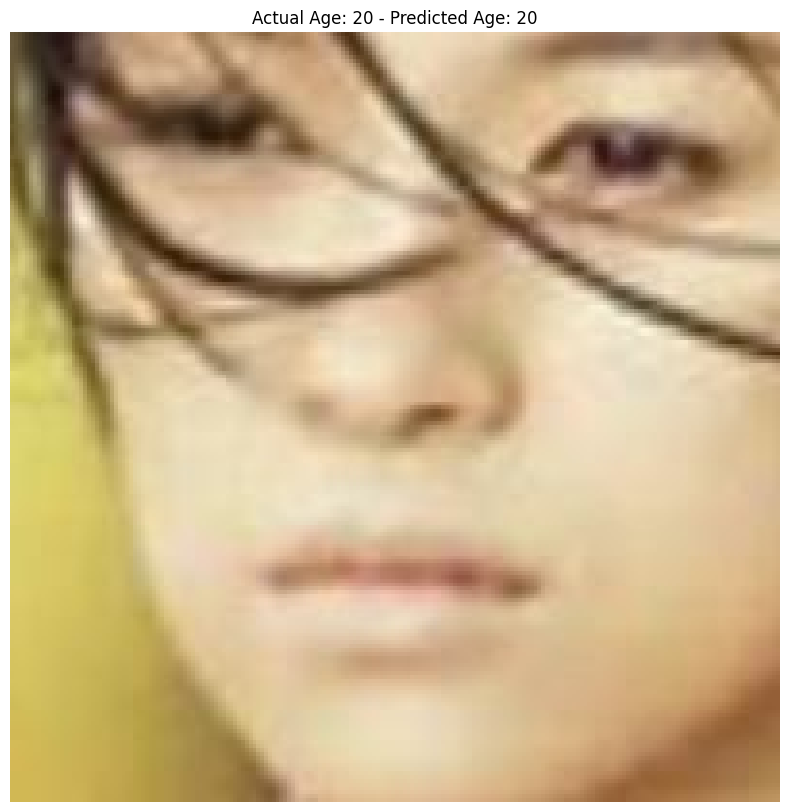

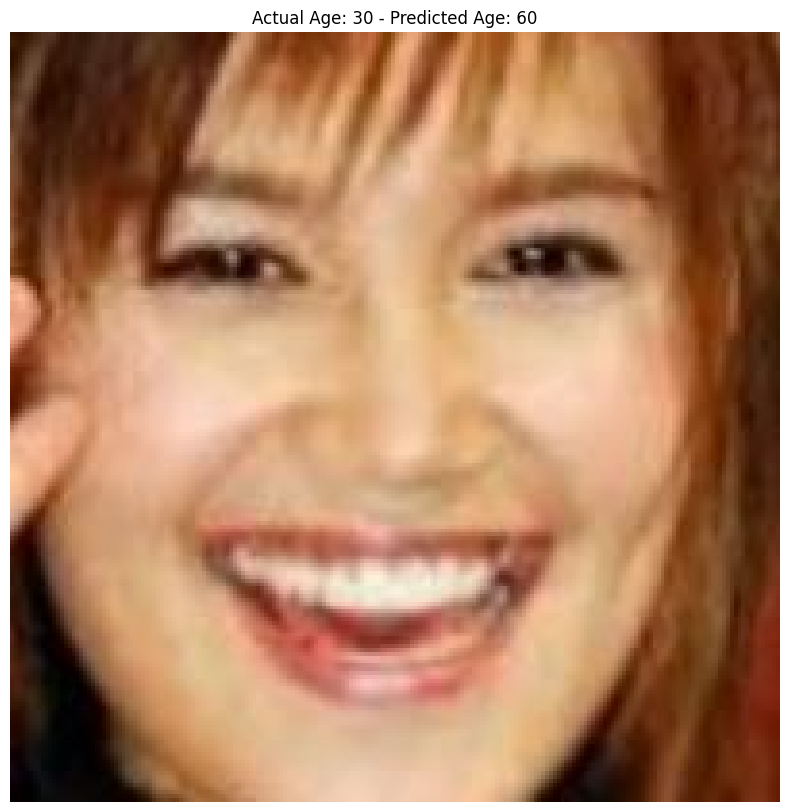

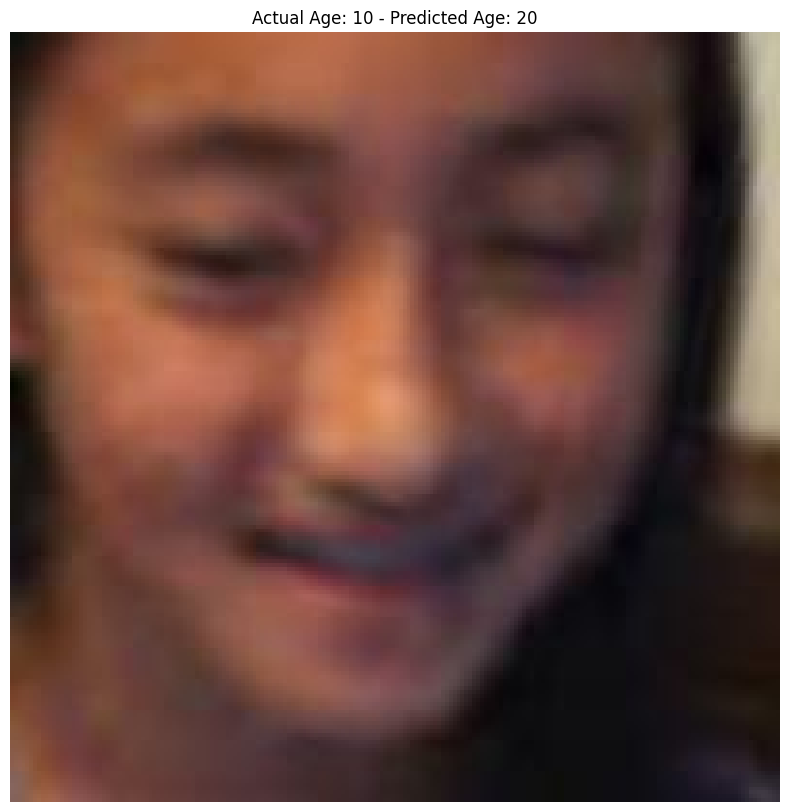

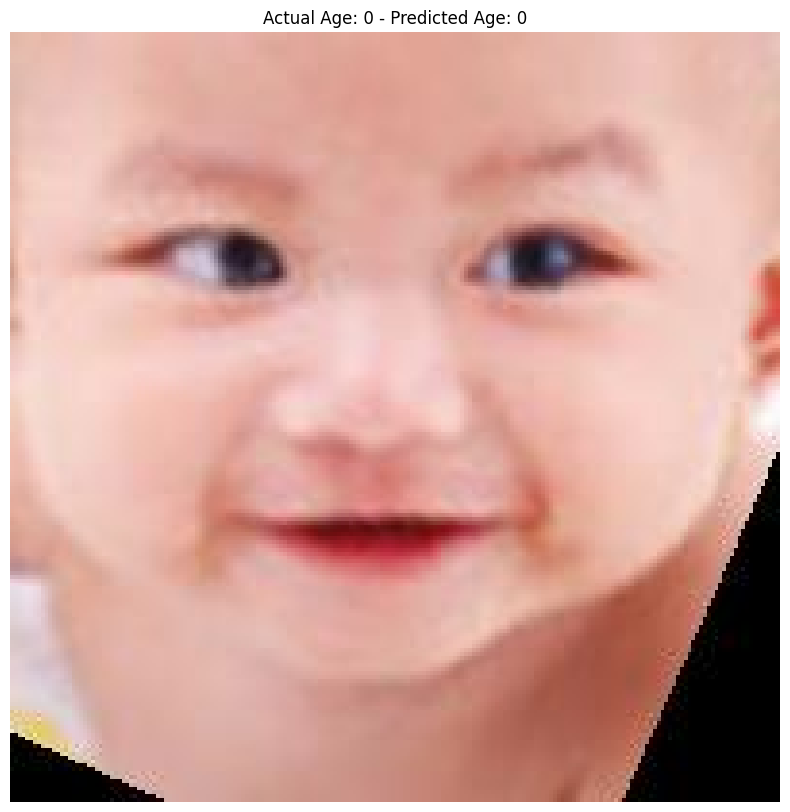

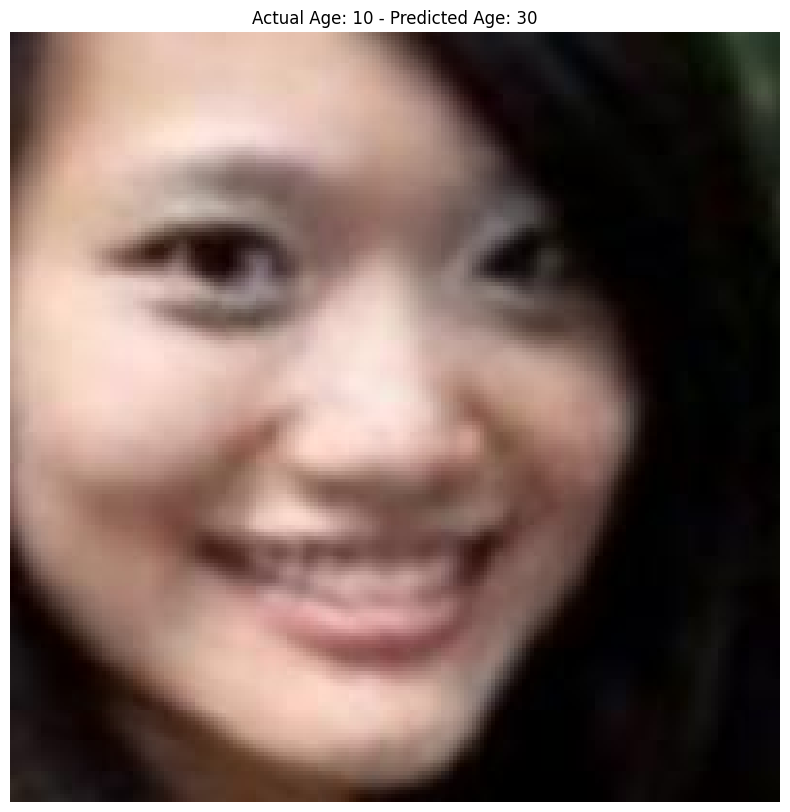

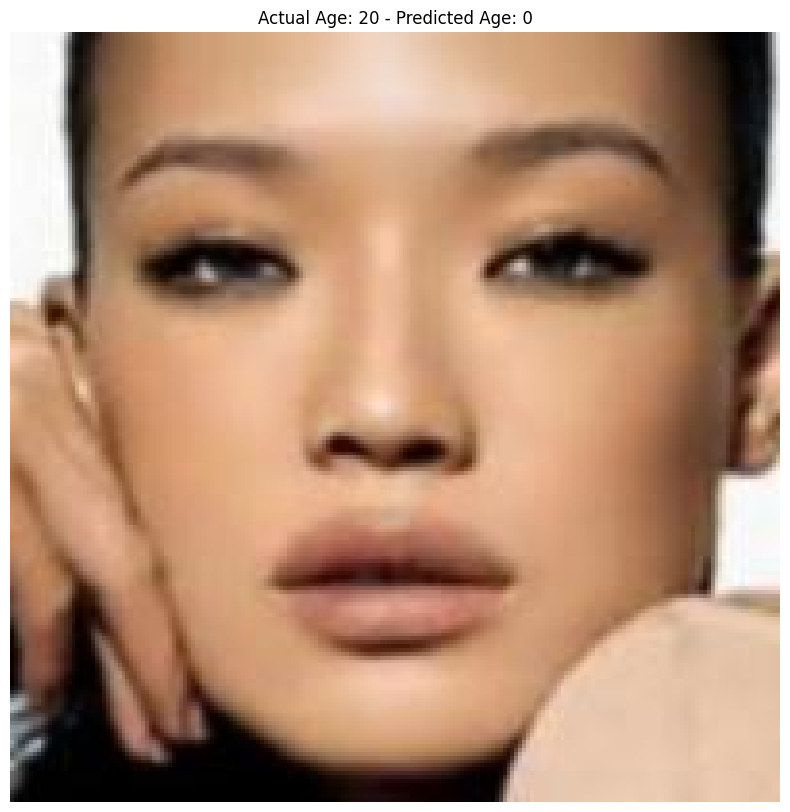

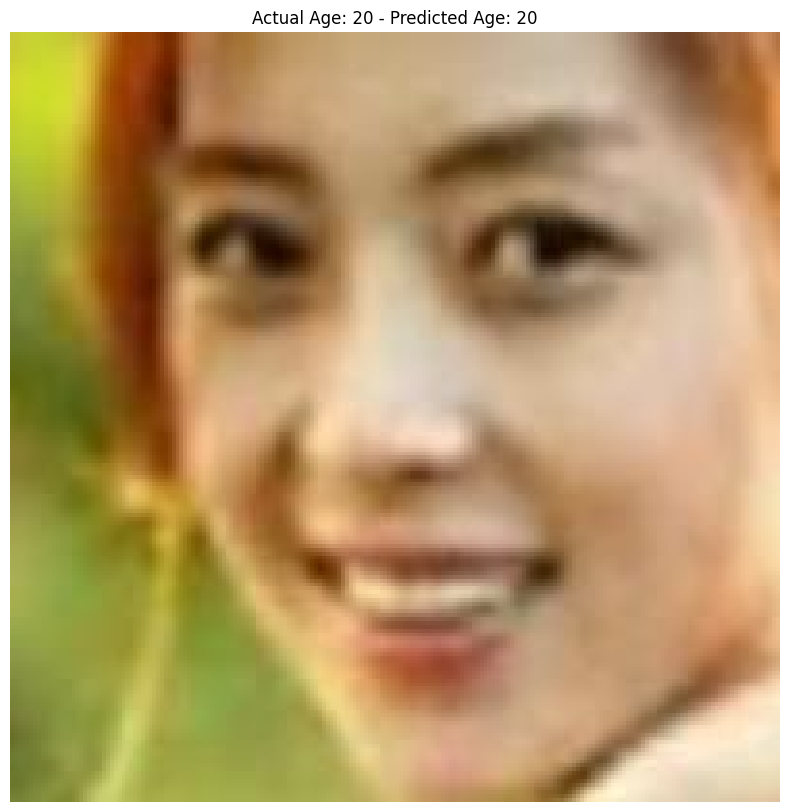

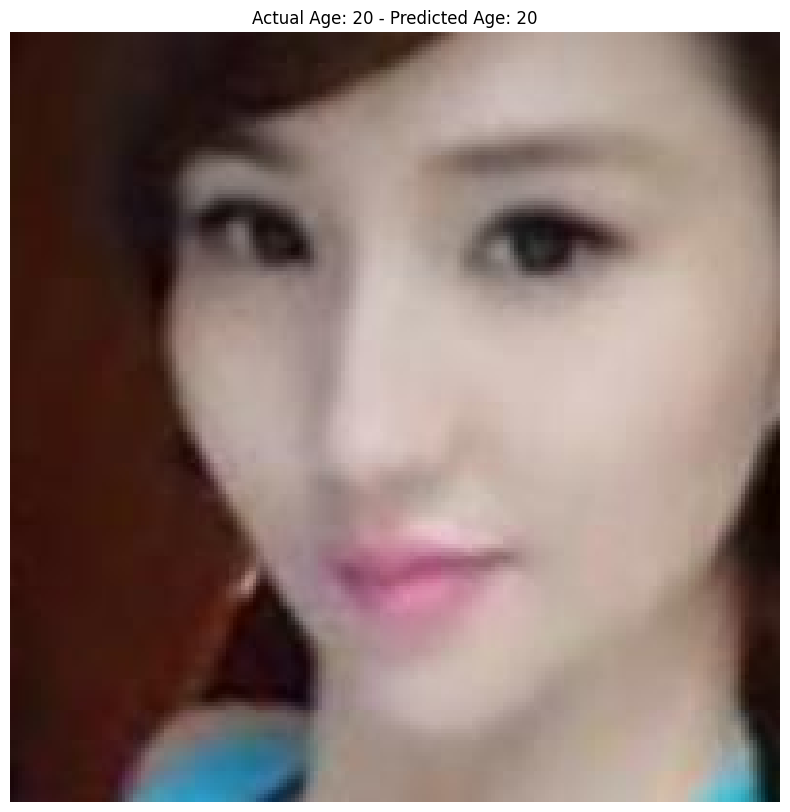

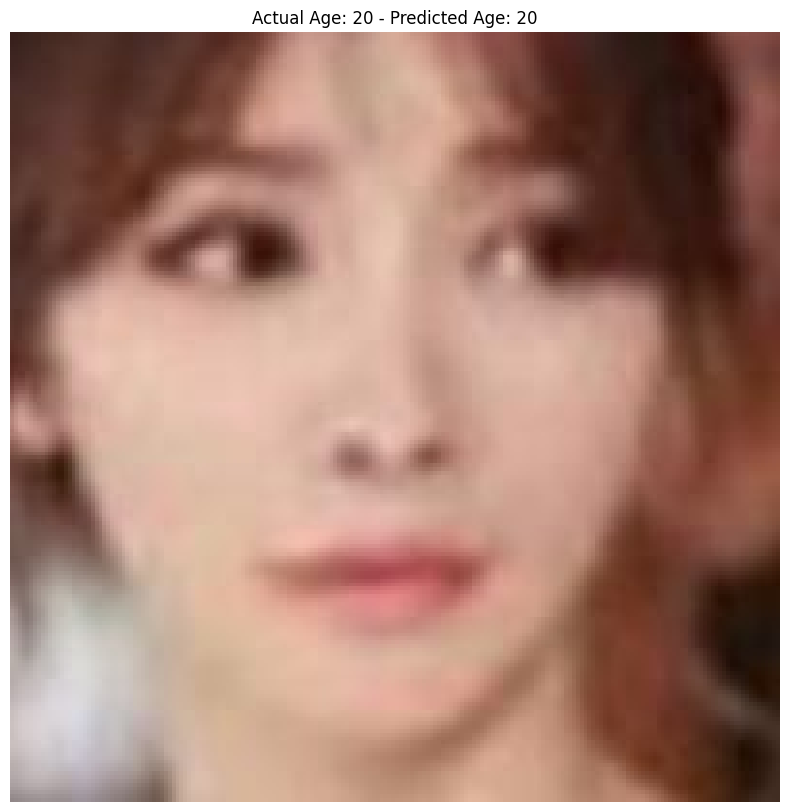

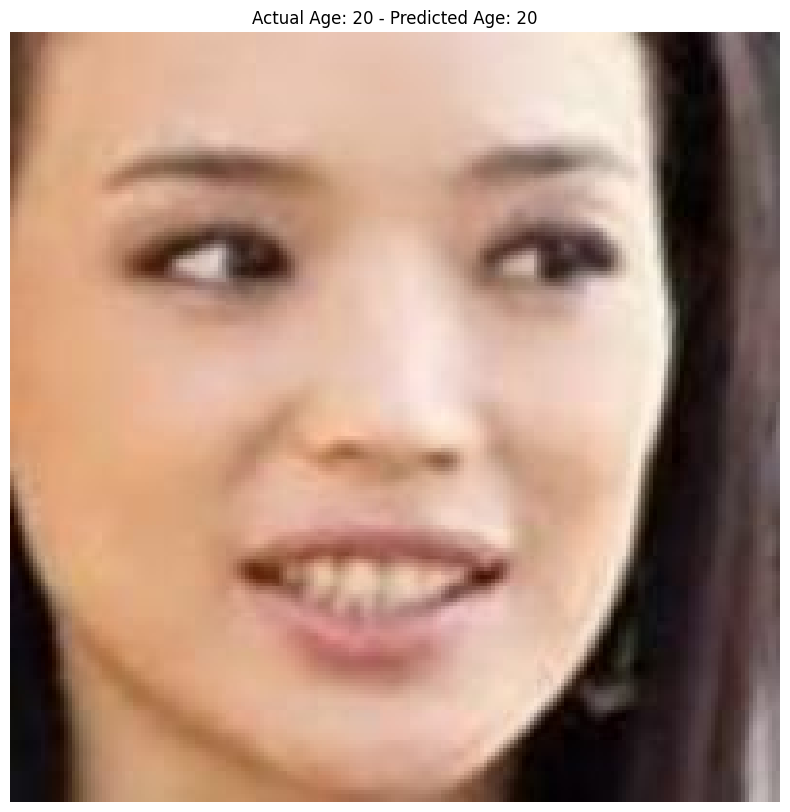

Accuracy: 60.00%


In [ ]:
# Fix random seed for reproducibility
seed = 123
np.random.seed(seed)

w = 32
h = 32

# Function to extract age from filename
def extract_age_from_filename(filename):
    filename_parts = filename.split("/")[-1].split("_")
    age = int(filename_parts[0])
    return age

# Load filenames of all images in UTKFaces folder
all_filenames = glob.glob('/content/drive/MyDrive/Colab Notebooks/UTKFaces/*.jpg')

# Filter out selected filenames from all filenames to get unseen filenames
unseen_filenames = [filename for filename in all_filenames if filename not in selected_filenames]

# Randomly select 10 unseen filenames
unseen_filenames = np.random.choice(unseen_filenames, 10, replace=False)

X_unseen = []

# Iterate through the unseen filenames
for filename in unseen_filenames:
    # Convert each image to grayscale
    im = Image.open(filename).convert('L')
    # Resize the images
    im = im.resize((w, h), Image.ANTIALIAS)
    # Convert to numpy array
    arr = np.array(im)
    # Normalize the images
    arr = arr / 255.0
    # Add images to the list
    X_unseen.append(arr)

# Convert list to numpy array
X_unseen = np.array(X_unseen)

# Reshape X_unseen to fit the model input shape
X_unseen = X_unseen.reshape(X_unseen.shape[0], w, h, 1).astype('float32')

# Use the model to predict age range for unseen images
predictions = modelC.predict(X_unseen)

# Extract actual age range from filenames
actual_age_ranges = [extract_age_from_filename(filename) // 10 for filename in unseen_filenames]

# Convert predictions to age range indices
predicted_age_ranges = np.argmax(predictions, axis=1)

# Calculate accuracy
correct_predictions = np.sum(predicted_age_ranges == actual_age_ranges)
total_predictions = len(actual_age_ranges)
accuracy = correct_predictions / total_predictions * 100

# Iterate through each unseen image, its actual age, and predicted age
for i in range(len(unseen_filenames)):
    # Extract actual age range from filename
    actual_age_range = extract_age_from_filename(unseen_filenames[i]) // 10
    # Extract predicted age range
    predicted_age_range = predicted_age_ranges[i]
    # Load the original image
    image = Image.open(unseen_filenames[i])
    # Plot the image
    plt.imshow(image)
    plt.title(f"Actual Age: {actual_age_range * 10} - Predicted Age: {predicted_age_range * 10}")
    plt.axis('off')
    plt.show()

print(f"Accuracy: {accuracy:.2f}%")

In [ ]:
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.scorecam import Scorecam
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.activation_maximization.callbacks import Progress
from tf_keras_vis.activation_maximization.input_modifiers import Jitter, Rotate2D
from tf_keras_vis.activation_maximization.regularizers import TotalVariation2D, Norm
from tf_keras_vis.utils.model_modifiers import ExtractIntermediateLayer, ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from matplotlib import cm

def plot_gradcam_plusplus_of_a_model(model, Xt, Xraw, image_titles, class_values):
    # Assuming you have already defined CategoricalScore, GradcamPlusPlus, and ReplaceToLinear
    score = CategoricalScore(class_values)
    # Create GradCAM++ visualization object
    gradcam = GradcamPlusPlus(model,
                          model_modifier=ReplaceToLinear(),
                          clone=True)
    # Generate heatmap with GradCAM++
    cam = gradcam(score,
                  Xt,
                  penultimate_layer=-1)

    # Plot
    f, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 8))
    for i, title in enumerate(image_titles):
        heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
        ax[i].set_title(title, fontsize=16)
        ax[i].imshow(Xraw[i], cmap="gray")
        ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
        ax[i].axis('off')
    plt.tight_layout()
    plt.show()

<ipython-input-45-011fb724e097>:14: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im_resized = im_gray.resize((w, h), Image.ANTIALIAS)
<ipython-input-45-011fb724e097>:14: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im_resized = im_gray.resize((w, h), Image.ANTIALIAS)
<ipython-input-45-011fb724e097>:14: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im_resized = im_gray.resize((w, h), Image.ANTIALIAS)
<ipython-input-45-011fb724e097>:32: FutureWarning: The input object of type 'JpegImageFile' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `

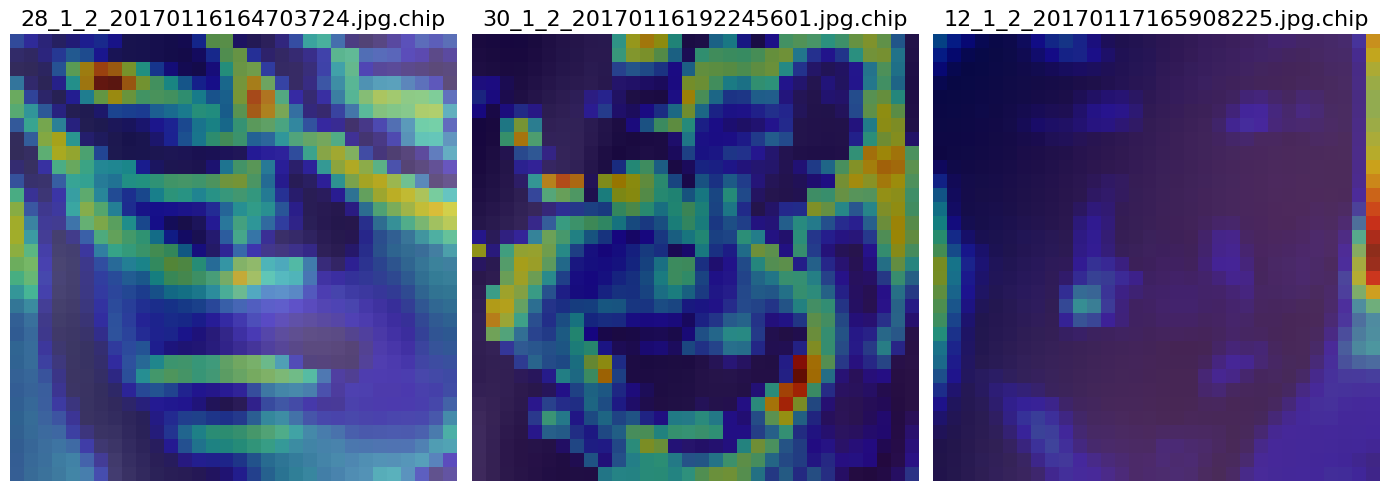

In [ ]:
# Initialize lists to store image data and metadata
Xt = []
Xraw = []
image_titles = []
class_values = []

# Assuming you have defined w and h earlier
for filename in unseen_filenames[:3]:  # Adjust the slice if you want to use fewer than 3 images
    im = Image.open(filename)
    im.show()  # Show the image
    # Convert image to grayscale
    im_gray = im.convert('L')
    # Resize the image
    im_resized = im_gray.resize((w, h), Image.ANTIALIAS)
    # Convert image to numpy array
    im_array = np.array(im_resized)
    # Normalize the image data
    im_array_normalized = im_array / 255.0
    # Append the normalized image to Xt
    Xt.append(im_array_normalized)
    # Append the original image to Xraw
    Xraw.append(im)
    # Extract the image name without extension
    name = os.path.splitext(os.path.basename(filename))[0]
    # Append the image title
    image_titles.append(name)
    # Append the class value (if applicable)
    class_values.append(0)  # Adjust the class value as needed

# Convert lists to numpy arrays
Xt = np.array(Xt)
Xraw = np.array(Xraw)

# Reshape Xt to fit the model input shape
Xt = Xt.reshape(Xt.shape[0], w, h, 1).astype('float32')

# Call the function to plot GradCAM++ of the model
plot_gradcam_plusplus_of_a_model(modelC, Xt, Xraw, image_titles, class_values)

<ipython-input-46-8b30d1fd35fe>:14: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im_resized = im_gray.resize((w, h), Image.ANTIALIAS)
<ipython-input-46-8b30d1fd35fe>:14: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im_resized = im_gray.resize((w, h), Image.ANTIALIAS)
<ipython-input-46-8b30d1fd35fe>:14: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im_resized = im_gray.resize((w, h), Image.ANTIALIAS)
<ipython-input-46-8b30d1fd35fe>:32: FutureWarning: The input object of type 'JpegImageFile' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `

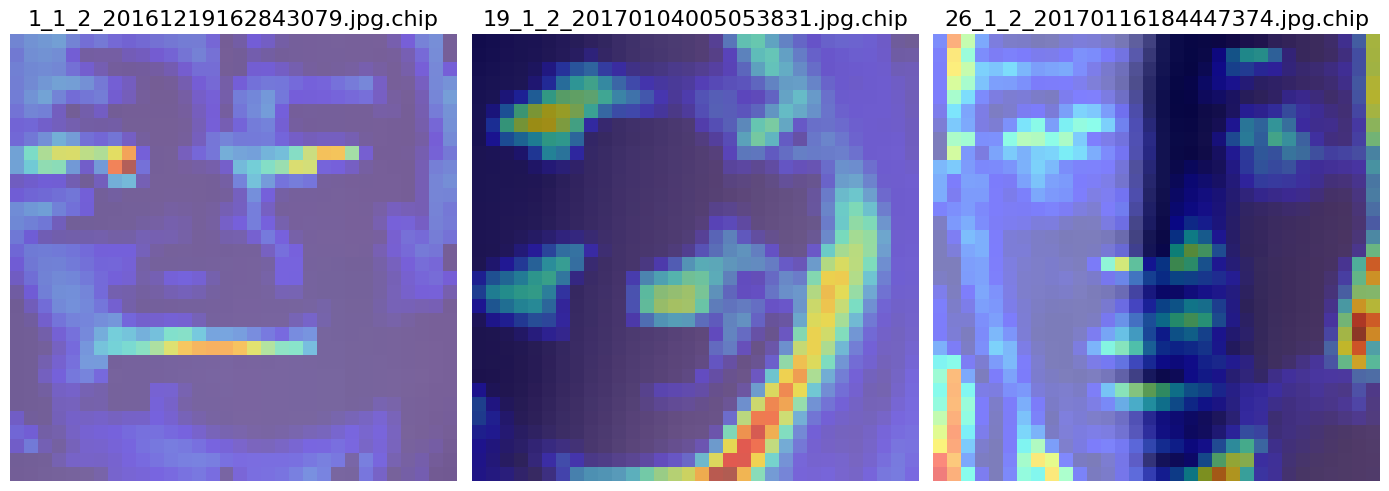

In [ ]:
# Initialize lists to store image data and metadata
Xt = []
Xraw = []
image_titles = []
class_values = []

# Assuming you have defined w and h earlier
for filename in unseen_filenames[3:6]:  # Adjust the slice if you want to use fewer than 3 images
    im = Image.open(filename)
    im.show()  # Show the image
    # Convert image to grayscale
    im_gray = im.convert('L')
    # Resize the image
    im_resized = im_gray.resize((w, h), Image.ANTIALIAS)
    # Convert image to numpy array
    im_array = np.array(im_resized)
    # Normalize the image data
    im_array_normalized = im_array / 255.0
    # Append the normalized image to Xt
    Xt.append(im_array_normalized)
    # Append the original image to Xraw
    Xraw.append(im)
    # Extract the image name without extension
    name = os.path.splitext(os.path.basename(filename))[0]
    # Append the image title
    image_titles.append(name)
    # Append the class value (if applicable)
    class_values.append(0)  # Adjust the class value as needed

# Convert lists to numpy arrays
Xt = np.array(Xt)
Xraw = np.array(Xraw)

# Reshape Xt to fit the model input shape
Xt = Xt.reshape(Xt.shape[0], w, h, 1).astype('float32')

# Call the function to plot GradCAM++ of the model
plot_gradcam_plusplus_of_a_model(modelC, Xt, Xraw, image_titles, class_values)

<ipython-input-47-a64afed397be>:14: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im_resized = im_gray.resize((w, h), Image.ANTIALIAS)
<ipython-input-47-a64afed397be>:14: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im_resized = im_gray.resize((w, h), Image.ANTIALIAS)
<ipython-input-47-a64afed397be>:14: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im_resized = im_gray.resize((w, h), Image.ANTIALIAS)
<ipython-input-47-a64afed397be>:32: FutureWarning: The input object of type 'JpegImageFile' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `

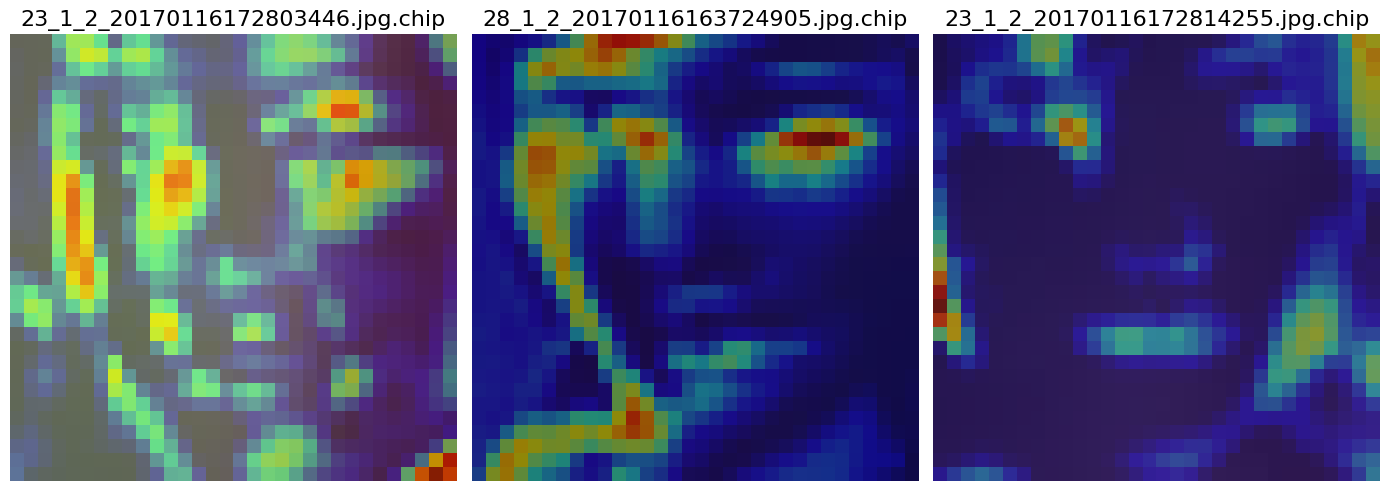

In [ ]:
# Initialize lists to store image data and metadata
Xt = []
Xraw = []
image_titles = []
class_values = []

# Assuming you have defined w and h earlier
for filename in unseen_filenames[6:9]:  # Adjust the slice if you want to use fewer than 3 images
    im = Image.open(filename)
    im.show()  # Show the image
    # Convert image to grayscale
    im_gray = im.convert('L')
    # Resize the image
    im_resized = im_gray.resize((w, h), Image.ANTIALIAS)
    # Convert image to numpy array
    im_array = np.array(im_resized)
    # Normalize the image data
    im_array_normalized = im_array / 255.0
    # Append the normalized image to Xt
    Xt.append(im_array_normalized)
    # Append the original image to Xraw
    Xraw.append(im)
    # Extract the image name without extension
    name = os.path.splitext(os.path.basename(filename))[0]
    # Append the image title
    image_titles.append(name)
    # Append the class value (if applicable)
    class_values.append(0)  # Adjust the class value as needed

# Convert lists to numpy arrays
Xt = np.array(Xt)
Xraw = np.array(Xraw)

# Reshape Xt to fit the model input shape
Xt = Xt.reshape(Xt.shape[0], w, h, 1).astype('float32')

# Call the function to plot GradCAM++ of the model
plot_gradcam_plusplus_of_a_model(modelC, Xt, Xraw, image_titles, class_values)

<ipython-input-48-ac086bd428f5>:14: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im_resized = im_gray.resize((w, h), Image.ANTIALIAS)
<ipython-input-48-ac086bd428f5>:14: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im_resized = im_gray.resize((w, h), Image.ANTIALIAS)
<ipython-input-48-ac086bd428f5>:32: FutureWarning: The input object of type 'JpegImageFile' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'JpegImageFile', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Xraw = np.array(Xraw)
<ipython-input-48-ac08

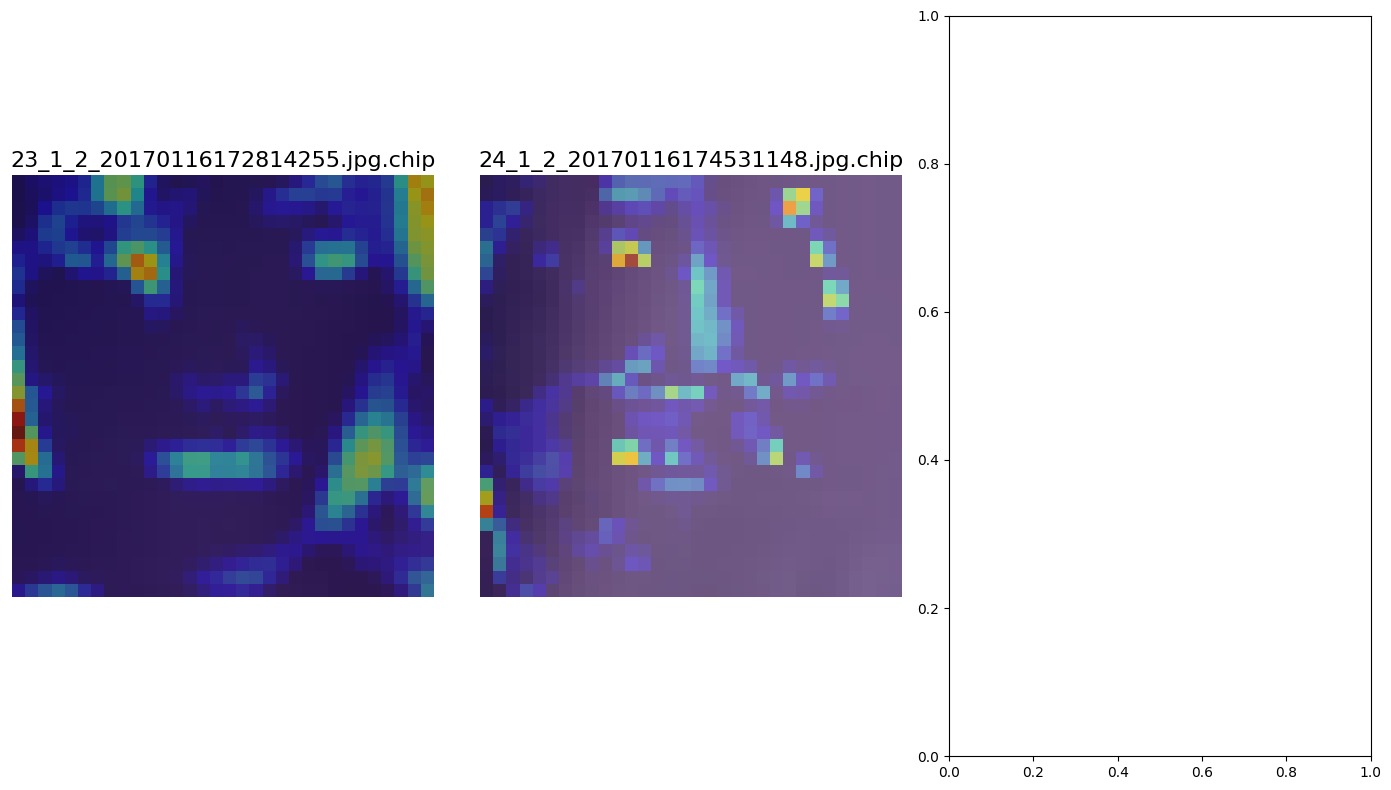

In [ ]:
# Initialize lists to store image data and metadata
Xt = []
Xraw = []
image_titles = []
class_values = []

# Assuming you have defined w and h earlier
for filename in unseen_filenames[8:]:  # Adjust the slice if you want to use fewer than 3 images
    im = Image.open(filename)
    im.show()  # Show the image
    # Convert image to grayscale
    im_gray = im.convert('L')
    # Resize the image
    im_resized = im_gray.resize((w, h), Image.ANTIALIAS)
    # Convert image to numpy array
    im_array = np.array(im_resized)
    # Normalize the image data
    im_array_normalized = im_array / 255.0
    # Append the normalized image to Xt
    Xt.append(im_array_normalized)
    # Append the original image to Xraw
    Xraw.append(im)
    # Extract the image name without extension
    name = os.path.splitext(os.path.basename(filename))[0]
    # Append the image title
    image_titles.append(name)
    # Append the class value (if applicable)
    class_values.append(0)  # Adjust the class value as needed

# Convert lists to numpy arrays
Xt = np.array(Xt)
Xraw = np.array(Xraw)

# Reshape Xt to fit the model input shape
Xt = Xt.reshape(Xt.shape[0], w, h, 1).astype('float32')

# Call the function to plot GradCAM++ of the model
plot_gradcam_plusplus_of_a_model(modelC, Xt, Xraw, image_titles, class_values)

### Conclusion

The model was trained on a dataset of Asian female faces for age classification. Given the wide age distribution, the task was structured as a 12-class classification problem using 10-year intervals.

The best-performing CNN architecture was:

```python
modelC = Sequential()
modelC.add(Conv2D(32, (3, 3), strides=1, padding="valid", input_shape=(w, h, 1), activation='relu'))
modelC.add(MaxPooling2D(pool_size=(2, 2), padding="valid"))
modelC.add(Flatten())
modelC.add(Dense(256, activation='relu'))
modelC.add(Dense(256, activation='relu'))
modelC.add(Dense(num_classes, activation='softmax'))
```

Best performance was achieved with a kernel size of 5 and a batch size of 8.

**Results Summary:**

* Accuracy was highest for the 0–10 age range (100%) and lowest for >80 (30%).
* Frequent misclassifications include:

  * 30 y/o predicted as 20 y/o
  * Elderly faces occasionally classified as 0–10
* Heatmaps indicate that relevant facial features (eyes, mouth, wrinkles) are generally used for predictions, though sometimes hair distracts the model.

**Future Work:**
Simplifying the classification task to broader age groups (e.g., child, young adult, adult, senior) could improve accuracy, especially in overlapping ranges like 20–40. However, it's unclear if this would significantly improve performance for elderly classes.


In [ ]:
# Saving the model
import time

modelC.summary()

ts = int(time.time())
file_path = f"drive/MyDrive/production/{tf}"
modelC.save(filepath=file_path, save_format="tf")


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 flatten_15 (Flatten)        (None, 6272)              0         
                                                                 
 dense_33 (Dense)            (None, 256)               1605888   
                                                                 
 dense_34 (Dense)            (None, 256)               65792     
                                                                 
 dense_35 (Dense)            (None, 12)                3084      
                                                     

In [ ]:
ts = str(int(time.time()))
file_path = ts
modelC.save(filepath=file_path, save_format='tf')

#creates a zip file which can be downloaded and unzipped
import shutil
shutil.make_archive("drive/MyDrive/production/"+ts, 'zip', ts)

'/content/drive/MyDrive/production/1714388676.zip'